In [1]:
#!/usr/bin/env python3
"""
NSE Options Analyzer - Combined PCR & Max Pain Calculator (Updated)

Changes / improvements in this version:
- Minor refactors and helpers (safe casting, logging)
- More robust cookie warmup & retry/backoff logic
- Safer JSON checks for NSE responses
- CSV write tolerant to IO errors
- calculate_max_pain returns numeric max_pain safely (handles float strikes)
- ThreadPoolExecutor uses a small worker pool by default (configurable)
- Avoid raising on symbols w/o options; returns empty results instead
"""

import os
import sys
import time
import random
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict, Optional, Any

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# CONFIGURATION
# ==========================
BASE_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "nse_options_analysis")
WARMUP_URL = "https://www.nseindia.com/option-chain"
EQUITY_OC_URL = "https://www.nseindia.com/api/option-chain-equities?symbol={symbol}"
INDEX_OC_URL = "https://www.nseindia.com/api/option-chain-indices?symbol={symbol}"
INDEX_OC_URL_ALT = "https://www.nseindia.com/api/option-chain-indices/?symbol={symbol}"

# Keep your full tickers list here (unchanged)
RAW_TICKERS = [
    'NSE:360ONE', 'NSE:ABB', 'NSE:ADANIENSOL', 'NSE:ADANIENT', 'NSE:ADANIGREEN', 'NSE:ADANIPORTS',
    'NSE:ATGL', 'NSE:ABCAPITAL', 'NSE:ABFRL', 'NSE:ALKEM', 'NSE:AMBER', 'NSE:AMBUJACEM',
    'NSE:ANGELONE', 'NSE:APLAPOLLO', 'NSE:APOLLOHOSP', 'NSE:ASHOKLEY', 'NSE:ASIANPAINT',
    'NSE:ASTRAL', 'NSE:AUBANK', 'NSE:AUROPHARMA', 'NSE:DMART', 'NSE:AXISBANK', 'NSE:BAJAJ-AUTO',
    'NSE:BAJFINANCE', 'NSE:BAJAJFINSV', 'NSE:BANDHANBNK', 'NSE:BANKBARODA', 'NSE:BANKINDIA',
    'NSE:BDL', 'NSE:BEL', 'NSE:BHARATFORG', 'NSE:BHEL', 'NSE:BPCL', 'NSE:BHARTIARTL',
    'NSE:BIOCON', 'NSE:BLUESTARCO', 'NSE:BOSCHLTD', 'NSE:BRITANNIA', 'NSE:BSE', 'NSE:CANBK',
    'NSE:CDSL', 'NSE:CESC', 'NSE:CGPOWER', 'NSE:CHOLAFIN', 'NSE:CIPLA', 'NSE:COALINDIA',
    'NSE:COFORGE', 'NSE:COLPAL', 'NSE:CAMS', 'NSE:CONCOR', 'NSE:CROMPTON', 'NSE:CUMMINSIND',
    'NSE:CYIENT', 'NSE:DABUR', 'NSE:DALBHARAT', 'NSE:DELHIVERY', 'NSE:DIVISLAB', 'NSE:DIXON',
    'NSE:DLF', 'NSE:DRREDDY', 'NSE:EICHERMOT', 'NSE:ETERNAL', 'NSE:EXIDEIND', 'NSE:FORTIS',
    'NSE:NYKAA', 'NSE:GAIL', 'NSE:GLENMARK', 'NSE:GMRAIRPORT', 'NSE:GODREJCP', 'NSE:GODREJPROP',
    'NSE:GRANULES', 'NSE:GRASIM', 'NSE:HAVELLS', 'NSE:HCLTECH', 'NSE:HDFCAMC', 'NSE:HDFCBANK',
    'NSE:HDFCLIFE', 'NSE:HEROMOTOCO', 'NSE:HFCL', 'NSE:HINDALCO', 'NSE:HAL', 'NSE:HINDPETRO',
    'NSE:HINDUNILVR', 'NSE:HINDZINC', 'NSE:HUDCO', 'NSE:ICICIBANK', 'NSE:ICICIGI', 'NSE:ICICIPRULI',
    'NSE:IDEA', 'NSE:IDFCFIRSTB', 'NSE:IIFL', 'NSE:INDIANB', 'NSE:IEX', 'NSE:IOC', 'NSE:IRCTC',
    'NSE:IRFC', 'NSE:IREDA', 'NSE:IGL', 'NSE:INDUSTOWER', 'NSE:INDUSINDBK', 'NSE:NAUKRI',
    'NSE:INFY', 'NSE:INOXWIND', 'NSE:INDIGO', 'NSE:IRB', 'NSE:ITC', 'NSE:JSL', 'NSE:JINDALSTEL',
    'NSE:JIOFIN', 'NSE:JSWENERGY', 'NSE:JSWSTEEL', 'NSE:JUBLFOOD', 'NSE:KALYANKJIL', 'NSE:KAYNES',
    'NSE:KEI', 'NSE:KFINTECH', 'NSE:KOTAKBANK', 'NSE:KPITTECH', 'NSE:LTF', 'NSE:LT', 'NSE:LAURUSLABS',
    'NSE:LICHSGFIN', 'NSE:LICI', 'NSE:LTIM', 'NSE:LUPIN', 'NSE:LODHA', 'NSE:MANAPPURAM',
    'NSE:MANKIND', 'NSE:MARICO', 'NSE:MARUTI', 'NSE:MFSL', 'NSE:MAXHEALTH', 'NSE:MAZDOCK',
    'NSE:MOTHERSON', 'NSE:MPHASIS', 'NSE:MCX', 'NSE:MUTHOOTFIN', 'NSE:NATIONALUM', 'NSE:NBCC',
    'NSE:NCC', 'NSE:NESTLEIND', 'NSE:NHPC', 'NSE:NMDC', 'NSE:NTPC', 'NSE:NUVAMA',
    'NSE:OBEROIRLTY', 'NSE:ONGC', 'NSE:OIL', 'NSE:PAYTM', 'NSE:OFSS', 'NSE:PAGEIND', 'NSE:PATANJALI',
    'NSE:POLICYBZR', 'NSE:PERSISTENT', 'NSE:PETRONET', 'NSE:PGEL', 'NSE:PIIND', 'NSE:PIDILITIND',
    'NSE:PPLPHARMA', 'NSE:PNBHOUSING', 'NSE:POLYCAB', 'NSE:POONAWALLA', 'NSE:PFC', 'NSE:POWERGRID',
    'NSE:PRESTIGE', 'NSE:PNB', 'NSE:RVNL', 'NSE:RBLBANK', 'NSE:RELIANCE', 'NSE:RECLTD', 'NSE:SBICARD',
    'NSE:SBILIFE', 'NSE:SHREECEM', 'NSE:SHRIRAMFIN', 'NSE:SIEMENS', 'NSE:SJVN', 'NSE:SOLARINDS',
    'NSE:SONACOMS', 'NSE:SRF', 'NSE:SBIN', 'NSE:SAIL', 'NSE:SUNPHARMA', 'NSE:SUPREMEIND', 'NSE:SUZLON',
    'NSE:SYNGENE', 'NSE:TATACHEM', 'NSE:TCS', 'NSE:TATACONSUM', 'NSE:TATAELXSI', 'NSE:TATAMOTORS',
    'NSE:TATAPOWER', 'NSE:TATASTEEL', 'NSE:TATATECH', 'NSE:TECHM', 'NSE:FEDERALBNK', 'NSE:INDHOTEL',
    'NSE:PHOENIXLTD', 'NSE:TITAGARH', 'NSE:TITAN', 'NSE:TORNTPHARM', 'NSE:TORNTPOWER', 'NSE:TRENT',
    'NSE:TIINDIA', 'NSE:TVSMOTOR', 'NSE:ULTRACEMCO', 'NSE:UNIONBANK', 'NSE:UNITDSPR', 'NSE:UNOMINDA',
    'NSE:UPL', 'NSE:VBL', 'NSE:VEDL', 'NSE:VOLTAS', 'NSE:WIPRO', 'NSE:YESBANK', 'NSE:ZYDUSLIFE'
]

INDEX_LIST = ["NIFTY", "BANKNIFTY"]
INDEX_SYMBOLS = set(INDEX_LIST)

ENABLE_PLOTS = False
VERBOSE_ERRORS = False

# Network / retry settings
DEFAULT_TIMEOUT = 15
WARMUP_RETRIES = 5
FETCH_RETRIES = 3
BACKOFF_BASE = 1.5

# ==========================
# HELPERS
# ==========================
def log(msg: str):
    """Simple console logger (replace with proper logger if desired)"""
    print(msg, flush=True)

def safe_cast_num(x: Any, t=float, default=None):
    """Safe numeric cast that tolerates None / NaN / strings"""
    try:
        if x is None or (hasattr(x, "isna") and x.isna()):
            return default
        return t(x)
    except Exception:
        return default

def strip_prefix(t: str) -> str:
    """Remove 'NSE:' prefix"""
    return t.split(":", 1)[1] if ":" in t else t

# ==========================
# HTTP HELPERS
# ==========================
def new_session() -> requests.Session:
    s = requests.Session()
    s.headers.update({
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/115.0.0.0 Safari/537.36"),
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive",
        "Referer": "https://www.nseindia.com/option-chain",
        "Host": "www.nseindia.com",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    })
    return s

def warm_cookies(session: requests.Session, retries=WARMUP_RETRIES, sleep_min=0.8, sleep_max=1.6) -> bool:
    """Warm up NSE cookies by visiting the site a couple times"""
    for i in range(retries):
        try:
            resp = session.get(WARMUP_URL, timeout=DEFAULT_TIMEOUT, allow_redirects=True)
            if resp.status_code == 200:
                # visit derivatives page to improve cookie footprint
                time.sleep(random.uniform(0.2, 0.6))
                session.get("https://www.nseindia.com/get-quotes/derivatives", timeout=DEFAULT_TIMEOUT)
                return True
            # follow redirect
            if resp.status_code in (301, 302, 307, 308) and 'Location' in resp.headers:
                session.get(resp.headers['Location'], timeout=DEFAULT_TIMEOUT)
                return True
        except requests.exceptions.RequestException:
            # Simple backoff
            time.sleep(random.uniform(sleep_min, sleep_max) * (i + 1))
        except Exception:
            if VERBOSE_ERRORS:
                traceback.print_exc()
            time.sleep(random.uniform(sleep_min, sleep_max) * (i + 1))
    return False

def is_valid_option_json(data: dict) -> bool:
    """Check if NSE option-chain JSON appears valid"""
    if not isinstance(data, dict):
        return False
    records = data.get("records")
    if not records or not isinstance(records, dict):
        return False
    # 'data' might be an array of strike rows
    if not records.get("data"):
        return False
    return True

def fetch_option_chain(session: requests.Session, symbol: str, is_index=False, retries=FETCH_RETRIES, backoff=BACKOFF_BASE):
    """Fetch NSE option-chain JSON for a symbol. Returns JSON or None."""
    urls = [EQUITY_OC_URL.format(symbol=symbol)]
    if is_index:
        urls = [INDEX_OC_URL.format(symbol=symbol), INDEX_OC_URL_ALT.format(symbol=symbol)]
    
    for url in urls:
        for attempt in range(retries):
            try:
                resp = session.get(url, timeout=DEFAULT_TIMEOUT)
                if resp.status_code == 200:
                    try:
                        data = resp.json()
                        if is_valid_option_json(data):
                            return data
                        else:
                            # probably blocked or invalid content
                            if VERBOSE_ERRORS:
                                log(f"  ⚠ Invalid option JSON for {symbol} at attempt {attempt+1}")
                            warm_cookies(session)
                            time.sleep(backoff * (attempt + 1))
                            continue
                    except ValueError:
                        # not JSON -> possible block
                        if VERBOSE_ERRORS:
                            log(f"  ⚠ Non-JSON response for {symbol} at attempt {attempt+1}")
                        warm_cookies(session)
                        time.sleep(backoff * (attempt + 1))
                        continue
                elif resp.status_code == 404:
                    return None
                elif resp.status_code in (429, 503, 403):
                    # rate-limited or blocked
                    time.sleep(backoff * (attempt + 1))
                    continue
                else:
                    time.sleep(backoff * (attempt + 1))
            except requests.exceptions.Timeout:
                time.sleep(backoff * (attempt + 1))
            except requests.exceptions.RequestException as e:
                if VERBOSE_ERRORS:
                    log(f"  ⚠ Request error for {symbol}: {e}")
                time.sleep(backoff * (attempt + 1))
            except Exception:
                if VERBOSE_ERRORS:
                    traceback.print_exc()
                time.sleep(backoff * (attempt + 1))
    return None

# ==========================
# DATA PROCESSING HELPERS
# ==========================
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def parse_rows_for_expiry(data: dict, expiry: str) -> List[Dict]:
    """Extract option chain rows for a specific expiry date, with safe numeric casting."""
    rows = []
    for rec in data.get("records", {}).get("data", []):
        if rec.get("expiryDate") != expiry:
            continue
        strike = safe_cast_num(rec.get("strikePrice"), float, None)
        ce = rec.get("CE", {}) or {}
        pe = rec.get("PE", {}) or {}
        rows.append({
            "Strike": strike,
            "Expiry": expiry,
            "Call_OI": safe_cast_num(ce.get("openInterest"), int, 0) or 0,
            "Call_LTP": safe_cast_num(ce.get("lastPrice"), float, None),
            "Put_OI": safe_cast_num(pe.get("openInterest"), int, 0) or 0,
            "Put_LTP": safe_cast_num(pe.get("lastPrice"), float, None),
            "CE_BidQty": safe_cast_num(ce.get("bidQty"), int, None),
            "CE_BidPrice": safe_cast_num(ce.get("bidprice"), float, None),
            "CE_AskQty": safe_cast_num(ce.get("askQty"), int, None),
            "CE_AskPrice": safe_cast_num(ce.get("askPrice"), float, None),
            "PE_BidQty": safe_cast_num(pe.get("bidQty"), int, None),
            "PE_BidPrice": safe_cast_num(pe.get("bidprice"), float, None),
            "PE_AskQty": safe_cast_num(pe.get("askQty"), int, None),
            "PE_AskPrice": safe_cast_num(pe.get("askPrice"), float, None),
            "CE_IV": safe_cast_num(ce.get("impliedVolatility"), float, None),
            "PE_IV": safe_cast_num(pe.get("impliedVolatility"), float, None),
            "Underlying": ce.get("underlying") or pe.get("underlying"),
            "UnderlyingValue": safe_cast_num(ce.get("underlyingValue") or pe.get("underlyingValue"), float, None),
        })
    return rows

def compute_pcr(rows: List[Dict]):
    """Calculate Put-Call Ratio (PCR): Put_OI / Call_OI. Returns totals and PCR (None if undefined)."""
    total_call_oi = sum((r.get("Call_OI") or 0) for r in rows)
    total_put_oi = sum((r.get("Put_OI") or 0) for r in rows)
    pcr = (total_put_oi / total_call_oi) if total_call_oi else None
    return int(total_call_oi), int(total_put_oi), (round(pcr, 6) if pcr is not None else None)

# ==========================
# MAX PAIN
# ==========================
def calculate_max_pain(df: pd.DataFrame) -> Optional[Dict]:
    """
    Calculate max pain for an option chain (strike with minimum total loss to writers).
    Returns dict with numeric 'max_pain_strike' and 'min_loss'.
    """
    try:
        required = ['Strike', 'Call_OI', 'Put_OI']
        if not all(col in df.columns for col in required):
            return None
        df2 = df.copy()
        df2 = df2.dropna(subset=required)
        if df2.empty:
            return None
        strikes = df2['Strike'].values.astype(float)
        call_oi = df2['Call_OI'].values.astype(float)
        put_oi = df2['Put_OI'].values.astype(float)
        if call_oi.sum() == 0 and put_oi.sum() == 0:
            return None
        total_losses = []
        # Use numpy vector ops for speed
        for expiry_price in strikes:
            call_loss = np.sum(np.clip(expiry_price - strikes, 0, None) * call_oi)
            put_loss = np.sum(np.clip(strikes - expiry_price, 0, None) * put_oi)
            total_losses.append(call_loss + put_loss)
        min_idx = int(np.argmin(total_losses))
        max_pain_strike = strikes[min_idx]
        min_loss = float(total_losses[min_idx])
        # return strike as numeric (int if whole number)
        if float(max_pain_strike).is_integer():
            max_pain_strike = int(max_pain_strike)
        return {'max_pain_strike': max_pain_strike, 'min_loss': min_loss}
    except Exception:
        if VERBOSE_ERRORS:
            traceback.print_exc()
        return None

def plot_max_pain(df: pd.DataFrame, title: str, save_path: str):
    try:
        strikes = df['Strike'].values.astype(float)
        call_oi = df['Call_OI'].values.astype(float)
        put_oi = df['Put_OI'].values.astype(float)
        total_losses = []
        for expiry_price in strikes:
            call_loss = np.sum(np.clip(expiry_price - strikes, 0, None) * call_oi)
            put_loss = np.sum(np.clip(strikes - expiry_price, 0, None) * put_oi)
            total_losses.append(call_loss + put_loss)
        plt.figure(figsize=(10, 6))
        plt.bar(strikes, total_losses, edgecolor='black', alpha=0.7)
        plt.xlabel("Strike Price")
        plt.ylabel("Total Loss (to Option Writers)")
        plt.title(title)
        plt.xticks(rotation=45)
        max_idx = int(np.argmin(total_losses))
        max_pain = strikes[max_idx]
        plt.axvline(max_pain, color='red', linestyle='--', linewidth=2, label=f"Max Pain = {max_pain}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        plt.close()
    except Exception:
        if VERBOSE_ERRORS:
            traceback.print_exc()

# ==========================
# SYMBOL / INDEX PROCESSING
# ==========================
def process_symbol(session: requests.Session, raw_symbol: str, target_expiries: List[str], out_base: str):
    """
    Process a single equity symbol:
      - fetch option-chain JSON
      - save per-expiry CSVs
      - compute PCR and Max Pain
    Returns list of dicts or empty list if no data.
    """
    symbol = strip_prefix(raw_symbol).upper()
    is_index = symbol in INDEX_SYMBOLS
    data = fetch_option_chain(session, symbol, is_index=is_index)
    if data is None:
        # try warming cookies and retry once
        warm_cookies(session)
        time.sleep(random.uniform(0.3, 0.8))
        data = fetch_option_chain(session, symbol, is_index=is_index)
    if data is None:
        return []
    found_expiries = set(data.get("records", {}).get("expiryDates", []))
    if not found_expiries:
        return []
    out_dir = os.path.join(out_base, symbol)
    ensure_dir(out_dir)
    pcr_maxpain_out = []
    for expiry in target_expiries:
        if expiry not in found_expiries:
            continue
        rows = parse_rows_for_expiry(data, expiry)
        if not rows:
            continue
        df = pd.DataFrame(rows).sort_values("Strike").reset_index(drop=True)
        # save CSV
        fname = f"{symbol}_{expiry}.csv".replace("/", "-")
        out_path = os.path.join(out_dir, fname)
        try:
            df.to_csv(out_path, index=False)
        except Exception:
            if VERBOSE_ERRORS:
                log(f"[WARN] Error writing {out_path}")
        tcoi, tpoi, pcr = compute_pcr(rows)
        max_pain_result = calculate_max_pain(df)
        max_pain_strike = max_pain_result['max_pain_strike'] if max_pain_result else None
        if ENABLE_PLOTS and max_pain_result:
            plot_path = os.path.join(out_dir, f"{symbol}_{expiry}_MaxPain.png".replace("/", "-"))
            plot_title = f"{symbol} - {expiry} Max Pain Analysis"
            plot_max_pain(df, plot_title, plot_path)
        pcr_maxpain_out.append({
            "Symbol": symbol,
            "Expiry": expiry,
            "Total_Call_OI": tcoi,
            "Total_Put_OI": tpoi,
            "PCR": pcr,
            "Max_Pain_Strike": max_pain_strike
        })
    return pcr_maxpain_out

def process_symbol_threadsafe(raw_symbol: str, target_expiries: List[str], out_base: str):
    s = new_session()
    # attempt warm once (safe)
    try:
        warm_cookies(s)
    except Exception:
        if VERBOSE_ERRORS:
            traceback.print_exc()
    time.sleep(random.uniform(0.1, 0.5))
    try:
        return process_symbol(s, raw_symbol, target_expiries, out_base)
    except Exception:
        if VERBOSE_ERRORS:
            traceback.print_exc()
        return []

def process_index_all_expiries(session: requests.Session, symbol: str, out_base: str):
    """Process all expiries for an index and save a master summary CSV"""
    symbol = symbol.upper()
    data = fetch_option_chain(session, symbol, is_index=True)
    if data is None:
        raise RuntimeError(f"No option data available for index {symbol}")
    expiries = data.get("records", {}).get("expiryDates", [])
    if not expiries:
        raise RuntimeError(f"No expiries found for index {symbol}")
    out_dir = os.path.join(out_base, symbol)
    ensure_dir(out_dir)
    pcr_maxpain_rows = []
    for expiry in expiries:
        rows = parse_rows_for_expiry(data, expiry)
        if not rows:
            # write an empty csv for transparency
            df_empty = pd.DataFrame(columns=[
                "Strike", "Expiry", "Call_OI", "Call_LTP", "Put_OI", "Put_LTP",
                "CE_BidQty", "CE_BidPrice", "CE_AskQty", "CE_AskPrice",
                "PE_BidQty", "PE_BidPrice", "PE_AskQty", "PE_AskPrice",
                "CE_IV", "PE_IV", "Underlying", "UnderlyingValue"
            ])
            out_path = os.path.join(out_dir, f"{symbol}_{expiry}.csv".replace("/", "-"))
            try:
                df_empty.to_csv(out_path, index=False)
            except Exception:
                if VERBOSE_ERRORS:
                    log(f"[WARN] Error writing empty CSV {out_path}")
            pcr_maxpain_rows.append({
                "Expiry": expiry,
                "Total_Call_OI": 0,
                "Total_Put_OI": 0,
                "PCR": None,
                "Max_Pain_Strike": None
            })
            continue
        df = pd.DataFrame(rows).sort_values("Strike").reset_index(drop=True)
        out_path = os.path.join(out_dir, f"{symbol}_{expiry}.csv".replace("/", "-"))
        try:
            df.to_csv(out_path, index=False)
        except Exception:
            if VERBOSE_ERRORS:
                log(f"[WARN] Error writing {out_path}")
        tcoi, tpoi, pcr = compute_pcr(rows)
        max_pain_result = calculate_max_pain(df)
        max_pain_strike = max_pain_result['max_pain_strike'] if max_pain_result else None
        if ENABLE_PLOTS and max_pain_result:
            plot_path = os.path.join(out_dir, f"{symbol}_{expiry}_MaxPain.png".replace("/", "-"))
            plot_title = f"{symbol} - {expiry} Max Pain Analysis"
            plot_max_pain(df, plot_title, plot_path)
        pcr_maxpain_rows.append({
            "Expiry": expiry,
            "Total_Call_OI": tcoi,
            "Total_Put_OI": tpoi,
            "PCR": pcr,
            "Max_Pain_Strike": max_pain_strike
        })
    master_df = pd.DataFrame(pcr_maxpain_rows, columns=["Expiry", "Total_Call_OI", "Total_Put_OI", "PCR", "Max_Pain_Strike"])
    master_name = f"{symbol}_Analysis_Summary.csv"
    master_path = os.path.join(out_dir, master_name)
    try:
        master_df.sort_values("Expiry", inplace=True)
        master_df.to_csv(master_path, index=False)
        log(f"  ✓ {symbol} summary saved ({len(master_df)} expiries)")
    except Exception as e:
        log(f"  [ERROR] Writing index master file {master_path}: {e}")
    return pcr_maxpain_rows

# ==========================
# MAIN EXECUTION
# ==========================
def main():
    print("=" * 70)
    print("NSE OPTIONS ANALYZER - PCR & MAX PAIN CALCULATOR")
    print("=" * 70)
    ensure_dir(BASE_DIR)
    print(f"\n📁 Output directory: {os.path.abspath(BASE_DIR)}\n")
    equities_out_base = BASE_DIR
    indices_base = os.path.join(BASE_DIR, "index_options")
    ensure_dir(indices_base)
    session = new_session()
    if not warm_cookies(session):
        log("[WARN] Warmup did not return 200 — proceeding anyway...\n")
    # target expiries from RELIANCE or fallback
    print("STEP 1: Determining target expiries from RELIANCE...")
    try:
        base_symbol = "RELIANCE"
        reliance_data = fetch_option_chain(session, base_symbol, is_index=False)
        if reliance_data is None:
            for fallback in ["SBIN", "HDFCBANK", "INFY", "TCS"]:
                log(f"  Trying fallback: {fallback}...")
                reliance_data = fetch_option_chain(session, fallback, is_index=False)
                if reliance_data:
                    base_symbol = fallback
                    break
        if reliance_data is None:
            raise RuntimeError("Cannot determine target expiries from any fallback symbol")
        target_expiries = reliance_data.get("records", {}).get("expiryDates", [])
        if len(target_expiries) < 3:
            raise RuntimeError(f"Could not find 3 expiries for {base_symbol}. Found: {target_expiries}")
        target_expiries = target_expiries[:3]
        print(f"✓ Using {base_symbol} expiries: {target_expiries}\n")
    except Exception as e:
        print(f"[FATAL] Cannot determine target expiries: {e}")
        if VERBOSE_ERRORS:
            traceback.print_exc()
        return
    # STEP 2: Process equities (multithreaded)
    print("=" * 70)
    print("STEP 2: Processing Equities (PCR + Max Pain)...")
    print("=" * 70)
    print("Note: Symbols without options data will be skipped silently\n")
    max_workers = min(6, max(2, (os.cpu_count() or 2)))  # keep small to avoid rate limits
    futures = []
    results = {exp: [] for exp in target_expiries}
    skipped_count = 0
    processed_count = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for raw in RAW_TICKERS:
            futures.append(executor.submit(process_symbol_threadsafe, raw, target_expiries, equities_out_base))
        completed = 0
        total = len(futures)
        for fut in as_completed(futures):
            completed += 1
            try:
                sym_results = fut.result()
                if sym_results:
                    processed_count += 1
                    for row in sym_results:
                        exp = row.get("Expiry")
                        if exp in results:
                            results[exp].append(row)
                else:
                    skipped_count += 1
            except Exception:
                skipped_count += 1
                if VERBOSE_ERRORS:
                    traceback.print_exc()
            print(f"  Progress: {completed}/{total} | ✓ Processed: {processed_count} | ⊘ Skipped: {skipped_count}", end='\r')
    print(f"\n\n✓ Completed: {processed_count} symbols with options data")
    print(f"⊘ Skipped: {skipped_count} symbols (no options data or errors)\n")
    print("Generating master equity summary files...")
    for exp in target_expiries:
        rows = results.get(exp, [])
        if not rows:
            print(f"  ⚠ No data for expiry {exp}")
            continue
        df = pd.DataFrame(rows, columns=["Symbol", "Expiry", "Total_Call_OI", "Total_Put_OI", "PCR", "Max_Pain_Strike"])
        df.sort_values("Symbol", inplace=True)
        master_name = f"Equities_Analysis_{exp}.csv".replace("/", "-")
        master_path = os.path.join(BASE_DIR, master_name)
        try:
            df.to_csv(master_path, index=False)
            print(f"  ✓ {master_name} ({len(df)} symbols)")
        except Exception as e:
            print(f"  [ERROR] Writing {master_path}: {e}")
    # STEP 3: Process indices
    print("\n" + "=" * 70)
    print("STEP 3: Processing Indices (PCR + Max Pain)...")
    print("=" * 70 + "\n")
    index_success = 0
    index_failed = 0
    for idx in INDEX_LIST:
        try:
            print(f"📊 Processing {idx}...")
            s = new_session()
            warm_cookies(s)
            process_index_all_expiries(s, idx, indices_base)
            index_success += 1
        except Exception as e:
            print(f"  [ERROR] Failed to process {idx}: {e}")
            index_failed += 1
            if VERBOSE_ERRORS:
                traceback.print_exc()
    # FINAL SUMMARY
    print("\n" + "=" * 70)
    print("✅ ANALYSIS COMPLETE!")
    print("=" * 70)
    print(f"\n📂 All results saved to: {os.path.abspath(BASE_DIR)}")
    print("\n📊 Summary:")
    print(f"  • Equities processed: {processed_count}/{len(RAW_TICKERS)}")
    print(f"  • Equities skipped: {skipped_count} (no options data)")
    print(f"  • Indices processed: {index_success}/{len(INDEX_LIST)}")
    if index_failed > 0:
        print(f"  • Indices failed: {index_failed}")
    print(f"  • Master equity files: {len(target_expiries)} expiries")
    print(f"  • Target expiries: {', '.join(target_expiries)}")
    if ENABLE_PLOTS:
        print("  ✓ Max Pain visualization plots (.png)")
    print("\n" + "=" * 70)
    # Save processing log
    log_path = os.path.join(BASE_DIR, "processing_log.txt")
    try:
        with open(log_path, 'w') as f:
            f.write("NSE Options Analysis - Processing Log\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Total tickers attempted: {len(RAW_TICKERS)}\n")
            f.write(f"Successfully processed: {processed_count}\n")
            f.write(f"Skipped (no options): {skipped_count}\n")
            f.write(f"Target expiries: {', '.join(target_expiries)}\n")
            f.write(f"\nIndices processed: {index_success}/{len(INDEX_LIST)}\n")
            if index_failed > 0:
                f.write(f"Indices failed: {index_failed}\n")
        print(f"📄 Processing log saved: processing_log.txt")
    except Exception:
        if VERBOSE_ERRORS:
            traceback.print_exc()

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⚠ Process interrupted by user")
        sys.exit(0)
    except Exception:
        print(f"\n[FATAL] Unhandled exception in main():")
        traceback.print_exc()
        sys.exit(1)

NSE OPTIONS ANALYZER - PCR & MAX PAIN CALCULATOR

📁 Output directory: C:\Users\sarda\Desktop\nse_options_analysis

STEP 1: Determining target expiries from RELIANCE...
✓ Using RELIANCE expiries: ['25-Nov-2025', '30-Dec-2025', '27-Jan-2026']

STEP 2: Processing Equities (PCR + Max Pain)...
Note: Symbols without options data will be skipped silently

  Progress: 215/215 | ✓ Processed: 205 | ⊘ Skipped: 10

✓ Completed: 205 symbols with options data
⊘ Skipped: 10 symbols (no options data or errors)

Generating master equity summary files...
  ✓ Equities_Analysis_25-Nov-2025.csv (205 symbols)
  ✓ Equities_Analysis_30-Dec-2025.csv (204 symbols)
  ✓ Equities_Analysis_27-Jan-2026.csv (197 symbols)

STEP 3: Processing Indices (PCR + Max Pain)...

📊 Processing NIFTY...
  ✓ NIFTY summary saved (18 expiries)
📊 Processing BANKNIFTY...
  ✓ BANKNIFTY summary saved (6 expiries)

✅ ANALYSIS COMPLETE!

📂 All results saved to: C:\Users\sarda\Desktop\nse_options_analysis

📊 Summary:
  • Equities processed

In [3]:
#!/usr/bin/env python3
"""
NSE Options Advanced Analyzer & Signal Generator (Updated)

Changes:
- Added safe formatting helper `format_price`
- Fixed SettingWithCopyWarning in analyze_iv (use .copy() and .loc)
- Use explicit `is None` checks instead of `if not pcr` to avoid treating 0 as missing
- More robust handling of missing data in generate_combined_signal
- Small improvements in recommend_strikes (use .dropna and safe casts)
- Add ensure_dir earlier and protect file IO
"""

import os
import sys
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================
# CONFIG
# ==========================
BASE_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "nse_options_analysis")
OUTPUT_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "nse_options_analysis_pro")
HISTORICAL_DIR = os.path.join(OUTPUT_DIR, "historical_tracking")
SIGNALS_DIR = os.path.join(OUTPUT_DIR, "trade_signals")
REPORTS_DIR = os.path.join(OUTPUT_DIR, "reports")

# thresholds
PCR_EXTREME_BULLISH = 1.5
PCR_EXTREME_BEARISH = 0.7
PCR_NEUTRAL_LOW = 0.9
PCR_NEUTRAL_HIGH = 1.1
MAX_PAIN_DISTANCE_THRESHOLD = 5.0
MAX_PAIN_STRONG_THRESHOLD = 8.0

IV_PERCENTILE_HIGH = 75
IV_PERCENTILE_LOW = 25

# ==========================
# HELPERS
# ==========================
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def get_today_str() -> str:
    return datetime.now().strftime("%Y-%m-%d")

def safe_float(val: Any, default=None) -> Optional[float]:
    try:
        if val is None or (hasattr(val, "isna") and val.isna()):
            return default
        return float(val)
    except Exception:
        return default

def format_price(val: Any) -> str:
    """Format numeric price to ₹x.xx or return 'N/A'"""
    try:
        if val is None or (hasattr(val, "isna") and val.isna()):
            return "N/A"
        return f"₹{float(val):.2f}"
    except Exception:
        return "N/A"

# ==========================
# DATA LOADING
# ==========================
def load_equity_analysis(expiry: str) -> Optional[pd.DataFrame]:
    file_path = os.path.join(BASE_DIR, f"Equities_Analysis_{expiry}.csv".replace("/", "-"))
    if not os.path.exists(file_path):
        print(f"⚠ File not found: {file_path}")
        return None
    return pd.read_csv(file_path)

def load_index_analysis(index_name: str) -> Optional[pd.DataFrame]:
    file_path = os.path.join(BASE_DIR, "index_options", index_name, f"{index_name}_Analysis_Summary.csv")
    if not os.path.exists(file_path):
        print(f"⚠ File not found: {file_path}")
        return None
    return pd.read_csv(file_path)

def load_option_chain(symbol: str, expiry: str, is_index=False) -> Optional[pd.DataFrame]:
    if is_index:
        file_path = os.path.join(BASE_DIR, "index_options", symbol, f"{symbol}_{expiry}.csv".replace("/", "-"))
    else:
        file_path = os.path.join(BASE_DIR, symbol, f"{symbol}_{expiry}.csv".replace("/", "-"))
    if not os.path.exists(file_path):
        return None
    return pd.read_csv(file_path)

def get_underlying_price(df: pd.DataFrame) -> Optional[float]:
    if 'UnderlyingValue' in df.columns:
        vals = df['UnderlyingValue'].dropna()
        if not vals.empty:
            return safe_float(vals.iloc[0])
    return None

# ==========================
# OI ANALYSIS
# ==========================
def analyze_oi_levels(df: pd.DataFrame) -> Dict:
    """Analyze OI distribution for support/resistance and totals"""
    if df is None or df.empty:
        return {}
    # ensure numeric
    df = df.copy()
    df['Call_OI'] = pd.to_numeric(df['Call_OI'], errors='coerce').fillna(0)
    df['Put_OI'] = pd.to_numeric(df['Put_OI'], errors='coerce').fillna(0)
    result = {}
    if df['Call_OI'].sum() > 0:
        max_call_oi_strike = df.loc[df['Call_OI'].idxmax(), 'Strike']
    else:
        max_call_oi_strike = None
    if df['Put_OI'].sum() > 0:
        max_put_oi_strike = df.loc[df['Put_OI'].idxmax(), 'Strike']
    else:
        max_put_oi_strike = None
    top_call_strikes = df.nlargest(3, 'Call_OI')[['Strike', 'Call_OI']].to_dict('records') if not df.empty else []
    top_put_strikes = df.nlargest(3, 'Put_OI')[['Strike', 'Put_OI']].to_dict('records') if not df.empty else []
    avg_call_oi = float(df['Call_OI'].mean()) if not df.empty else 0
    avg_put_oi = float(df['Put_OI'].mean()) if not df.empty else 0
    strong_resistance = df[df['Call_OI'] > 2 * avg_call_oi]['Strike'].tolist() if avg_call_oi > 0 else []
    strong_support = df[df['Put_OI'] > 2 * avg_put_oi]['Strike'].tolist() if avg_put_oi > 0 else []
    result.update({
        'max_call_oi_strike': safe_float(max_call_oi_strike),
        'max_put_oi_strike': safe_float(max_put_oi_strike),
        'top_call_strikes': top_call_strikes,
        'top_put_strikes': top_put_strikes,
        'strong_resistance_zones': strong_resistance,
        'strong_support_zones': strong_support,
        'total_call_oi': int(df['Call_OI'].sum()),
        'total_put_oi': int(df['Put_OI'].sum())
    })
    return result

# ==========================
# IV ANALYSIS (fixed SettingWithCopyWarning)
# ==========================
def analyze_iv(df: pd.DataFrame) -> Dict:
    if df is None or df.empty or 'CE_IV' not in df.columns or 'PE_IV' not in df.columns:
        return {}
    df_clean = df.dropna(subset=['CE_IV', 'PE_IV']).copy()
    if df_clean.empty:
        return {}
    df_clean['CE_IV'] = pd.to_numeric(df_clean['CE_IV'], errors='coerce')
    df_clean['PE_IV'] = pd.to_numeric(df_clean['PE_IV'], errors='coerce')
    avg_call_iv = float(df_clean['CE_IV'].mean())
    avg_put_iv = float(df_clean['PE_IV'].mean())
    iv_skew = avg_put_iv - avg_call_iv
    underlying = get_underlying_price(df)
    atm_call_iv = atm_put_iv = None
    if underlying is not None:
        # safe assignment using .loc and a copy
        df_clean.loc[:, 'distance'] = (df_clean['Strike'] - underlying).abs()
        atm_row = df_clean.loc[df_clean['distance'].idxmin()]
        atm_call_iv = safe_float(atm_row.get('CE_IV'))
        atm_put_iv = safe_float(atm_row.get('PE_IV'))
    return {
        'avg_call_iv': avg_call_iv,
        'avg_put_iv': avg_put_iv,
        'iv_skew': iv_skew,
        'atm_call_iv': atm_call_iv,
        'atm_put_iv': atm_put_iv,
        'max_call_iv': float(df_clean['CE_IV'].max()),
        'min_call_iv': float(df_clean['CE_IV'].min()),
        'max_put_iv': float(df_clean['PE_IV'].max()),
        'min_put_iv': float(df_clean['PE_IV'].min())
    }

# ==========================
# SIGNAL GENERATION (robust None handling)
# ==========================
def calculate_max_pain_signal(cmp: float, max_pain: float, pcr: float) -> Dict:
    if cmp is None or max_pain is None or pcr is None:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'Insufficient data'}
    distance_pct = ((max_pain - cmp) / cmp) * 100
    abs_distance = abs(distance_pct)
    if abs_distance < MAX_PAIN_DISTANCE_THRESHOLD:
        strength = 1
    elif abs_distance < MAX_PAIN_STRONG_THRESHOLD:
        strength = 2
    else:
        strength = 3
    if distance_pct > 0:
        if pcr > 1.0:
            signal = 'BULLISH'
            reason = f'CMP below Max Pain ({distance_pct:.2f}%), PCR={pcr:.2f} (bearish sentiment → contrarian bullish)'
        else:
            signal = 'WEAK_BULLISH'
            reason = f'CMP below Max Pain ({distance_pct:.2f}%) but PCR={pcr:.2f} (not confirming)'
    else:
        if pcr < 1.0:
            signal = 'BEARISH'
            reason = f'CMP above Max Pain ({abs(distance_pct):.2f}%), PCR={pcr:.2f} (bullish sentiment → contrarian bearish)'
        else:
            signal = 'WEAK_BEARISH'
            reason = f'CMP above Max Pain ({abs(distance_pct):.2f}%) but PCR={pcr:.2f} (not confirming)'
    return {'signal': signal, 'strength': strength, 'distance_pct': distance_pct, 'reason': reason}

def calculate_pcr_signal(pcr: float) -> Dict:
    if pcr is None:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'No PCR data'}
    if pcr >= PCR_EXTREME_BULLISH:
        strength = 3 if pcr > 1.8 else 2
        return {'signal': 'BULLISH', 'strength': strength, 'reason': f'Extreme bearish sentiment (PCR={pcr:.2f}) → Contrarian bullish'}
    elif pcr <= PCR_EXTREME_BEARISH:
        strength = 3 if pcr < 0.5 else 2
        return {'signal': 'BEARISH', 'strength': strength, 'reason': f'Extreme bullish sentiment (PCR={pcr:.2f}) → Contrarian bearish'}
    elif PCR_NEUTRAL_LOW <= pcr <= PCR_NEUTRAL_HIGH:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': f'PCR in neutral zone ({pcr:.2f})'}
    elif pcr > PCR_NEUTRAL_HIGH:
        return {'signal': 'WEAK_BULLISH', 'strength': 1, 'reason': f'Slightly bearish sentiment (PCR={pcr:.2f})'}
    else:
        return {'signal': 'WEAK_BEARISH', 'strength': 1, 'reason': f'Slightly bullish sentiment (PCR={pcr:.2f})'}

def calculate_oi_signal(cmp: float, oi_analysis: Dict) -> Dict:
    if cmp is None or not oi_analysis:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'No OI data'}
    resistance = oi_analysis.get('max_call_oi_strike')
    support = oi_analysis.get('max_put_oi_strike')
    if resistance is None or support is None:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'Insufficient OI data'}
    try:
        range_size = float(resistance) - float(support)
    except Exception:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'Invalid S/R levels'}
    if range_size <= 0:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'Invalid S/R levels'}
    position_pct = ((cmp - support) / range_size) * 100
    if position_pct < 25:
        signal = 'BULLISH'; reason = f'Near support ({support:.0f}), resistance at {resistance:.0f}'; strength = 2
    elif position_pct > 75:
        signal = 'BEARISH'; reason = f'Near resistance ({resistance:.0f}), support at {support:.0f}'; strength = 2
    else:
        signal = 'NEUTRAL'; reason = f'Mid-range between support {support:.0f} and resistance {resistance:.0f}'; strength = 0
    return {'signal': signal, 'strength': strength, 'reason': reason, 'support': support, 'resistance': resistance, 'position_pct': position_pct}

def calculate_iv_signal(iv_analysis: Dict) -> Dict:
    if not iv_analysis or 'atm_call_iv' not in iv_analysis:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'No IV data'}
    atm_call = iv_analysis.get('atm_call_iv') or 0
    atm_put = iv_analysis.get('atm_put_iv') or 0
    atm_iv = (atm_call + atm_put) / 2 if (atm_call or atm_put) else 0
    iv_skew = iv_analysis.get('iv_skew', 0)
    if atm_iv == 0:
        return {'signal': 'NEUTRAL', 'strength': 0, 'reason': 'No ATM IV data'}
    if atm_iv > 40:
        signal = 'SELL_OPTIONS'; strength = 2; reason = f'Very high IV ({atm_iv:.1f}%) → Favor premium selling'
    elif atm_iv > 30:
        signal = 'SELL_OPTIONS'; strength = 1; reason = f'High IV ({atm_iv:.1f}%) → Favor premium selling'
    elif atm_iv < 10:
        signal = 'BUY_OPTIONS'; strength = 2; reason = f'Very low IV ({atm_iv:.1f}%) → Favor option buying'
    elif atm_iv < 15:
        signal = 'BUY_OPTIONS'; strength = 1; reason = f'Low IV ({atm_iv:.1f}%) → Favor option buying'
    else:
        signal = 'NEUTRAL'; strength = 0; reason = f'Moderate IV ({atm_iv:.1f}%)'
    skew_note = ''
    if abs(iv_skew) > 3:
        skew_note = ' | Put IV > Call IV (bearish skew)' if iv_skew > 0 else ' | Call IV > Put IV (bullish skew)'
    return {'signal': signal, 'strength': strength, 'reason': reason + skew_note, 'atm_iv': atm_iv, 'iv_skew': iv_skew}

# ==========================
# COMBINED SIGNAL SCORING
# ==========================
def generate_combined_signal(symbol: str, expiry: str, is_index=False) -> Optional[Dict]:
    df = load_option_chain(symbol, expiry, is_index)
    if df is None or df.empty:
        return None
    cmp = get_underlying_price(df)
    if cmp is None:
        return None
    if is_index:
        summary = load_index_analysis(symbol)
        if summary is None:
            return None
        row = summary[summary['Expiry'] == expiry]
    else:
        summary = load_equity_analysis(expiry)
        if summary is None:
            return None
        row = summary[summary['Symbol'] == symbol]
    if row is None or row.empty:
        return None
    pcr = safe_float(row.iloc[0].get('PCR'))
    max_pain = safe_float(row.iloc[0].get('Max_Pain_Strike'))
    max_pain_sig = calculate_max_pain_signal(cmp, max_pain, pcr)
    pcr_sig = calculate_pcr_signal(pcr)
    oi_analysis = analyze_oi_levels(df)
    oi_sig = calculate_oi_signal(cmp, oi_analysis)
    iv_analysis = analyze_iv(df)
    iv_sig = calculate_iv_signal(iv_analysis)
    # map and score
    signal_map = {'BULLISH': 3, 'WEAK_BULLISH': 1, 'NEUTRAL': 0, 'WEAK_BEARISH': -1, 'BEARISH': -3}
    max_pain_score = signal_map.get(max_pain_sig['signal'], 0) * max_pain_sig.get('strength', 0)
    pcr_score = signal_map.get(pcr_sig['signal'], 0) * pcr_sig.get('strength', 0)
    oi_score = signal_map.get(oi_sig['signal'], 0) * oi_sig.get('strength', 0)
    total_score = max_pain_score + pcr_score + oi_score
    # compute max_possible: conservative denominator for confidence
    max_possible = (3 * 3) + (3 * 3) + (3 * 2)
    confidence_pct = (abs(total_score) / max_possible) * 100 if max_possible else 0
    if total_score >= 6:
        final_signal = 'STRONG_BULLISH'
    elif total_score >= 3:
        final_signal = 'BULLISH'
    elif total_score >= 1:
        final_signal = 'WEAK_BULLISH'
    elif total_score <= -6:
        final_signal = 'STRONG_BEARISH'
    elif total_score <= -3:
        final_signal = 'BEARISH'
    elif total_score <= -1:
        final_signal = 'WEAK_BEARISH'
    else:
        final_signal = 'NEUTRAL'
    return {
        'symbol': symbol,
        'expiry': expiry,
        'cmp': cmp,
        'max_pain': max_pain,
        'pcr': pcr,
        'final_signal': final_signal,
        'confidence_pct': confidence_pct,
        'total_score': total_score,
        'max_pain_signal': max_pain_sig,
        'pcr_signal': pcr_sig,
        'oi_signal': oi_sig,
        'iv_signal': iv_sig,
        'oi_analysis': oi_analysis,
        'iv_analysis': iv_analysis
    }

# ==========================
# STRIKE RECOMMENDATION (small safety improvements)
# ==========================
def recommend_strikes(signal_data: Dict, df: pd.DataFrame) -> Dict:
    if not signal_data or df is None or df.empty:
        return {}
    cmp = signal_data['cmp']
    final_signal = signal_data['final_signal']
    iv_signal = signal_data['iv_signal']['signal']
    recommendations = []
    df2 = df.dropna(subset=['Strike']).copy()
    # ensure numeric LTP columns
    df2['Call_LTP'] = pd.to_numeric(df2.get('Call_LTP'), errors='coerce')
    df2['Put_LTP'] = pd.to_numeric(df2.get('Put_LTP'), errors='coerce')
    # BUY/SELL logic
    if 'BULLISH' in final_signal:
        if iv_signal == 'BUY_OPTIONS':
            atm_calls = df2[df2['Strike'] >= cmp].nsmallest(3, 'Strike')
            for _, row in atm_calls.iterrows():
                strike = safe_float(row['Strike'])
                premium = safe_float(row['Call_LTP'], 0)
                if premium > 0:
                    risk = premium
                    potential_reward = max(0.0, strike * 0.05)
                    rr_ratio = potential_reward / risk if risk > 0 else 0
                    recommendations.append({
                        'type': 'BUY_CALL', 'strike': strike, 'premium': premium, 'risk': risk,
                        'potential_reward': potential_reward, 'rr_ratio': rr_ratio,
                        'description': f'Buy {strike} Call @ ₹{premium:.2f}'
                    })
        else:
            otm_puts = df2[df2['Strike'] < cmp].nlargest(3, 'Strike')
            for _, row in otm_puts.iterrows():
                strike = safe_float(row['Strike'])
                premium = safe_float(row['Put_LTP'], 0)
                if premium > 0:
                    risk = strike * 0.1
                    reward = premium
                    rr_ratio = reward / risk if risk > 0 else 0
                    recommendations.append({
                        'type': 'SELL_PUT', 'strike': strike, 'premium': premium, 'reward': reward,
                        'risk': risk, 'rr_ratio': rr_ratio,
                        'description': f'Sell {strike} Put @ ₹{premium:.2f}'
                    })
    elif 'BEARISH' in final_signal:
        if iv_signal == 'BUY_OPTIONS':
            atm_puts = df2[df2['Strike'] <= cmp].nlargest(3, 'Strike')
            for _, row in atm_puts.iterrows():
                strike = safe_float(row['Strike'])
                premium = safe_float(row['Put_LTP'], 0)
                if premium > 0:
                    risk = premium
                    potential_reward = max(0.0, strike * 0.05)
                    rr_ratio = potential_reward / risk if risk > 0 else 0
                    recommendations.append({
                        'type': 'BUY_PUT', 'strike': strike, 'premium': premium, 'risk': risk,
                        'potential_reward': potential_reward, 'rr_ratio': rr_ratio,
                        'description': f'Buy {strike} Put @ ₹{premium:.2f}'
                    })
        else:
            otm_calls = df2[df2['Strike'] > cmp].nsmallest(3, 'Strike')
            for _, row in otm_calls.iterrows():
                strike = safe_float(row['Strike'])
                premium = safe_float(row['Call_LTP'], 0)
                if premium > 0:
                    risk = strike * 0.1
                    reward = premium
                    rr_ratio = reward / risk if risk > 0 else 0
                    recommendations.append({
                        'type': 'SELL_CALL', 'strike': strike, 'premium': premium, 'reward': reward,
                        'risk': risk, 'rr_ratio': rr_ratio,
                        'description': f'Sell {strike} Call @ ₹{premium:.2f}'
                    })
    recommendations.sort(key=lambda x: x.get('rr_ratio', 0), reverse=True)
    return {'top_trades': recommendations[:3] if recommendations else [], 'total_opportunities': len(recommendations)}

# ==========================
# HISTORICAL TRACKING
# ==========================
def append_to_historical(symbol: str, expiry: str, signal_data: Dict, is_index=False):
    if not signal_data:
        return
    today = get_today_str()
    row = {
        'Date': today,
        'Symbol': symbol,
        'Expiry': expiry,
        'CMP': signal_data['cmp'],
        'Max_Pain': signal_data['max_pain'],
        'PCR': signal_data['pcr'],
        'Final_Signal': signal_data['final_signal'],
        'Confidence_pct': signal_data['confidence_pct'],
        'Max_Pain_Distance_pct': signal_data['max_pain_signal'].get('distance_pct'),
        'ATM_IV': signal_data['iv_analysis'].get('atm_call_iv'),
        'IV_Skew': signal_data['iv_analysis'].get('iv_skew'),
        'Call_OI_Total': signal_data['oi_analysis'].get('total_call_oi'),
        'Put_OI_Total': signal_data['oi_analysis'].get('total_put_oi'),
        'Support': signal_data['oi_signal'].get('support'),
        'Resistance': signal_data['oi_signal'].get('resistance')
    }
    ensure_dir(HISTORICAL_DIR)
    hist_file = os.path.join(HISTORICAL_DIR, f"{symbol}_history.csv")
    if os.path.exists(hist_file):
        hist_df = pd.read_csv(hist_file)
        if not ((hist_df['Date'] == today) & (hist_df['Expiry'] == expiry)).any():
            hist_df = pd.concat([hist_df, pd.DataFrame([row])], ignore_index=True)
            hist_df.to_csv(hist_file, index=False)
    else:
        pd.DataFrame([row]).to_csv(hist_file, index=False)

# ==========================
# MAIN ANALYSIS FUNCTIONS
# ==========================
def generate_market_report(expiry: str):
    print(f"\n{'='*70}")
    print(f"MARKET ANALYSIS REPORT - {expiry}")
    print(f"{'='*70}\n")
    summary = load_equity_analysis(expiry)
    if summary is None:
        print("❌ No data available for this expiry")
        return
    all_signals = []
    print(f"Analyzing {len(summary)} stocks...\n")
    for idx, row in summary.iterrows():
        symbol = row['Symbol']
        signal_data = generate_combined_signal(symbol, expiry, is_index=False)
        if signal_data:
            all_signals.append(signal_data)
            append_to_historical(symbol, expiry, signal_data, is_index=False)
        if (idx + 1) % 10 == 0:
            print(f"  Analyzed: {idx + 1}/{len(summary)}", end='\r')
    print(f"\n")
    signals_df = pd.DataFrame([{
        'Symbol': s['symbol'],
        'CMP': s['cmp'],
        'Max_Pain': s['max_pain'],
        'PCR': s['pcr'],
        'Signal': s['final_signal'],
        'Confidence': f"{s['confidence_pct']:.1f}%",
        'Score': s['total_score']
    } for s in all_signals])
    ensure_dir(REPORTS_DIR)
    report_file = os.path.join(REPORTS_DIR, f"Market_Report_{expiry}_{get_today_str()}.csv".replace("/", "-"))
    signals_df.to_csv(report_file, index=False)
    print(f"📊 MARKET SUMMARY:")
    print(f"Total stocks analyzed: {len(signals_df)}\n")
    if not signals_df.empty:
        signal_counts = signals_df['Signal'].value_counts()
        for sig, count in signal_counts.items():
            print(f"  {sig}: {count}")
        print(f"\n🎯 TOP BULLISH OPPORTUNITIES:")
        bullish = signals_df[signals_df['Signal'].str.contains('BULLISH')].nlargest(10, 'Score')
        if not bullish.empty:
            print(bullish[['Symbol', 'CMP', 'Max_Pain', 'PCR', 'Signal', 'Confidence']].to_string(index=False))
        else:
            print("  None")
        print(f"\n🎯 TOP BEARISH OPPORTUNITIES:")
        bearish = signals_df[signals_df['Signal'].str.contains('BEARISH')].nsmallest(10, 'Score')
        if not bearish.empty:
            print(bearish[['Symbol', 'CMP', 'Max_Pain', 'PCR', 'Signal', 'Confidence']].to_string(index=False))
        else:
            print("  None")
    print(f"\n💾 Full report saved: {report_file}\n")
    return signals_df

def analyze_stock(symbol: str, expiry: str):
    print(f"\n{'='*70}")
    print(f"DETAILED ANALYSIS: {symbol} - {expiry}")
    print(f"{'='*70}\n")
    is_index = symbol in ['NIFTY', 'BANKNIFTY']
    signal_data = generate_combined_signal(symbol, expiry, is_index)
    if not signal_data:
        print("❌ No data available")
        return
    df = load_option_chain(symbol, expiry, is_index)
    print(f"📍 CMP: {format_price(signal_data['cmp'])}")
    print(f"🎯 Max Pain: {format_price(signal_data['max_pain'])}")
    pcr_val = signal_data.get('pcr')
    print(f"📊 PCR: {pcr_val:.4f}" if pcr_val is not None else "📊 PCR: N/A")
    print(f"📈 Distance from Max Pain: {signal_data['max_pain_signal'].get('distance_pct', 0):.2f}%\n")
    print(f"{'─'*70}\nSIGNAL BREAKDOWN:\n{'─'*70}\n")
    print(f"1️⃣ MAX PAIN: {signal_data['max_pain_signal']['signal']} ({'⭐' * signal_data['max_pain_signal']['strength']})")
    print(f"   {signal_data['max_pain_signal']['reason']}\n")
    print(f"2️⃣ PCR: {signal_data['pcr_signal']['signal']} ({'⭐' * signal_data['pcr_signal']['strength']})")
    print(f"   {signal_data['pcr_signal']['reason']}\n")
    print(f"3️⃣ OI: {signal_data['oi_signal']['signal']} ({'⭐' * signal_data['oi_signal']['strength']})")
    print(f"   {signal_data['oi_signal']['reason']}")
    if 'support' in signal_data['oi_signal'] and signal_data['oi_signal'].get('support') is not None:
        print(f"   Support: {format_price(signal_data['oi_signal']['support'])} | Resistance: {format_price(signal_data['oi_signal']['resistance'])}\n")
    print(f"4️⃣ IV: {signal_data['iv_signal']['signal']} ({'⭐' * signal_data['iv_signal']['strength']})")
    print(f"   {signal_data['iv_signal']['reason']}")
    if 'atm_iv' in signal_data['iv_signal'] and signal_data['iv_signal'].get('atm_iv') is not None:
        print(f"   ATM IV: {signal_data['iv_signal']['atm_iv']:.2f}%\n")
    print(f"{'─'*70}")
    print(f"🎯 FINAL SIGNAL: {signal_data['final_signal']}")
    print(f"📊 Confidence: {signal_data['confidence_pct']:.1f}%")
    print(f"💯 Composite Score: {signal_data['total_score']}")
    print(f"{'─'*70}\n")
    if df is not None and not df.empty:
        strikes = recommend_strikes(signal_data, df)
        if strikes and strikes.get('top_trades'):
            print(f"{'='*70}\nRECOMMENDED TRADES:\n{'='*70}\n")
            for i, trade in enumerate(strikes['top_trades'], 1):
                print(f"{i}. {trade['description']}")
                print(f"   Type: {trade['type']}")
                print(f"   Premium: ₹{trade.get('premium', 0):.2f}")
                if 'risk' in trade and 'potential_reward' in trade:
                    print(f"   Risk: ₹{trade['risk']:.2f}")
                    print(f"   Potential Reward: ₹{trade.get('potential_reward', 0):.2f}")
                    print(f"   Risk-Reward: 1:{trade.get('rr_ratio', 0):.2f}")
                print()
    append_to_historical(symbol, expiry, signal_data, is_index)
    return signal_data

def analyze_indices():
    print(f"\n{'='*70}\nINDEX ANALYSIS\n{'='*70}\n")
    results = {}
    for index in ['NIFTY', 'BANKNIFTY']:
        summary = load_index_analysis(index)
        if summary is None:
            print(f"❌ No data for {index}\n")
            continue
        print(f"{'-'*70}\n{index}\n{'-'*70}\n")
        index_results = []
        for _, row in summary.head(3).iterrows():
            expiry = row['Expiry']
            signal_data = generate_combined_signal(index, expiry, is_index=True)
            if signal_data:
                cmp_str = format_price(signal_data.get('cmp'))
                max_pain_str = format_price(signal_data.get('max_pain'))
                pcr_val = signal_data.get('pcr')
                pcr_str = f"{pcr_val:.4f}" if pcr_val is not None else "N/A"
                print(f"📅 {expiry}")
                print(f"   CMP: {cmp_str} | Max Pain: {max_pain_str} | PCR: {pcr_str}")
                print(f"   Signal: {signal_data['final_signal']} ({signal_data['confidence_pct']:.1f}% confidence)")
                print(f"   {signal_data['max_pain_signal']['reason']}\n")
                append_to_historical(index, expiry, signal_data, is_index=True)
                index_results.append(signal_data)
        results[index] = index_results
    return results

# ==========================
# INIT DIRECTORIES
# ==========================
print("Initializing analysis directories...")
ensure_dir(OUTPUT_DIR)
ensure_dir(HISTORICAL_DIR)
ensure_dir(SIGNALS_DIR)
ensure_dir(REPORTS_DIR)

if not os.path.exists(BASE_DIR):
    print(f"\n❌ Error: Base data not found at {BASE_DIR}")
    print("Please run the data collection script first!")
else:
    print(f"✅ Data found at: {BASE_DIR}")
    print(f"✅ Output will be saved to: {OUTPUT_DIR}")
    equity_files = [f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')]
    if equity_files:
        expiries = [f.replace('Equities_Analysis_', '').replace('.csv', '') for f in equity_files]
        print(f"\n📅 Available expiries: {', '.join(expiries)}")
        print("\n" + "="*70)
        print("READY TO ANALYZE!")
        print("="*70)
        print("\nAvailable functions:")
        print("  • generate_market_report(expiry) - Full market analysis")
        print("  • analyze_stock(symbol, expiry) - Detailed stock analysis")
        print("  • analyze_indices() - NIFTY & BANKNIFTY analysis")
        print("\nExample usage:")
        print(f"  df = generate_market_report('{expiries[0]}')")
        print(f"  analyze_stock('RELIANCE', '{expiries[0]}')")
        print("  analyze_indices()")
        print("\n" + "="*70 + "\n")
    else:
        print("\n❌ No equity analysis files found!")
        print("Please run the data collection script first!")

Initializing analysis directories...
✅ Data found at: C:\Users\sarda\Desktop\nse_options_analysis
✅ Output will be saved to: C:\Users\sarda\Desktop\nse_options_analysis_pro

📅 Available expiries: 25-Nov-2025, 27-Jan-2026, 30-Dec-2025

READY TO ANALYZE!

Available functions:
  • generate_market_report(expiry) - Full market analysis
  • analyze_stock(symbol, expiry) - Detailed stock analysis
  • analyze_indices() - NIFTY & BANKNIFTY analysis

Example usage:
  df = generate_market_report('25-Nov-2025')
  analyze_stock('RELIANCE', '25-Nov-2025')
  analyze_indices()




In [5]:
# Cell 3: Discover expiries and run market report for the nearest expiry
import os

# BASE_DIR should already be defined in Cell 2 (same kernel). If not, set it here:
# BASE_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "nse_options_analysis")

# Find equity analysis files
if not os.path.exists(BASE_DIR):
    print(f"❌ Base data directory not found: {BASE_DIR}")
    print("Please run the data collection script (Cell 1) first and ensure files are saved.")
else:
    equity_files = sorted([f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')])
    expiries = [f.replace('Equities_Analysis_', '').replace('.csv', '') for f in equity_files]
    print(f"Available expiries: {expiries}")

    if expiries:
        expiry = expiries[0]  # nearest expiry (first file found)
        print(f"\nAnalyzing nearest expiry: {expiry}\n")
        # Run the market report (this will produce CSV in REPORTS_DIR)
        try:
            market_df = generate_market_report(expiry)
            if market_df is None:
                print("No market report generated (likely missing or invalid data).")
            else:
                print(f"\nMarket report DataFrame shape: {market_df.shape}")
        except Exception as e:
            print(f"⚠ Error running market report for {expiry}: {e}")
    else:
        print("❌ No 'Equities_Analysis_<expiry>.csv' files found in BASE_DIR.")
        print("Run Cell 1 to collect data or verify the output directory.")

Available expiries: ['25-Nov-2025', '27-Jan-2026', '30-Dec-2025']

Analyzing nearest expiry: 25-Nov-2025


MARKET ANALYSIS REPORT - 25-Nov-2025

Analyzing 205 stocks...

  Analyzed: 200/205

📊 MARKET SUMMARY:
Total stocks analyzed: 205

  STRONG_BEARISH: 77
  BEARISH: 59
  WEAK_BEARISH: 32
  WEAK_BULLISH: 20
  NEUTRAL: 9
  STRONG_BULLISH: 6
  BULLISH: 2

🎯 TOP BULLISH OPPORTUNITIES:
    Symbol     CMP  Max_Pain      PCR         Signal Confidence
    CONCOR  521.50     540.0 0.756859 STRONG_BULLISH      25.0%
  EXIDEIND  378.85     390.0 0.712652 STRONG_BULLISH      25.0%
  GODREJCP 1127.00    1140.0 0.758327 STRONG_BULLISH      25.0%
       HAL 4787.00    4800.0 0.739450 STRONG_BULLISH      25.0%
    INDIGO 5586.00    5700.0 0.781855 STRONG_BULLISH      25.0%
     IRCTC  705.10     720.0 0.712330 STRONG_BULLISH      25.0%
JINDALSTEL 1072.80    1070.0 1.024826        BULLISH      20.8%
  PETRONET  277.50     290.0 1.149339        BULLISH      16.7%
BANDHANBNK  152.38     160.0 0.500579 

In [7]:
# Cell 4: Analyze index expiries (NIFTY & BANKNIFTY)
# This will iterate top 3 expiries saved for each index and print results.

try:
    print("\nRunning index analysis (NIFTY & BANKNIFTY)...\n")
    index_results = analyze_indices()
    # index_results is a dict: {'NIFTY': [...], 'BANKNIFTY': [...]}
    if index_results:
        for idx_name, lst in index_results.items():
            print(f"{idx_name}: {len(lst)} expiry analyses returned.")
    else:
        print("No index analysis results returned (check index CSVs under index_options/).")
except Exception as e:
    print(f"⚠ Error during index analysis: {e}")
    # if VERBOSE_ERRORS is True, you can uncomment the next line to see stack
    # import traceback; traceback.print_exc()


Running index analysis (NIFTY & BANKNIFTY)...


INDEX ANALYSIS

----------------------------------------------------------------------
NIFTY
----------------------------------------------------------------------

📅 02-Dec-2025
   CMP: ₹25574.35 | Max Pain: ₹25650.00 | PCR: 0.6426
   Signal: BEARISH (20.8% confidence)
   CMP below Max Pain (0.30%) but PCR=0.64 (not confirming)

📅 09-Dec-2025
   CMP: ₹25574.35 | Max Pain: ₹25600.00 | PCR: 1.3088
   Signal: BULLISH (16.7% confidence)
   CMP below Max Pain (0.10%), PCR=1.31 (bearish sentiment → contrarian bullish)

📅 11-Nov-2025
   CMP: ₹25574.35 | Max Pain: ₹25600.00 | PCR: 0.9688
   Signal: WEAK_BULLISH (4.2% confidence)
   CMP below Max Pain (0.10%) but PCR=0.97 (not confirming)

----------------------------------------------------------------------
BANKNIFTY
----------------------------------------------------------------------

📅 25-Nov-2025
   CMP: ₹57937.55 | Max Pain: ₹58000.00 | PCR: 0.9190
   Signal: WEAK_BULLISH (4.2% confidenc

C:\Users\sarda\AppData\Local\Temp\ipykernel_20396\2557908168.py:441: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hist_df = pd.concat([hist_df, pd.DataFrame([row])], ignore_index=True)


In [25]:
# Cell 5: Analyze individual stocks (example list). Change symbols as needed.

# Example list; edit to analyse other symbols
stocks_to_analyze = ['TECHM', 'JSWENERGY', 'DMART', 'DELHIVERY']

# Ensure we have expiries from Cell 3; if not, re-detect
try:
    equity_files = sorted([f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')])
    expiries = [f.replace('Equities_Analysis_', '').replace('.csv', '') for f in equity_files]
except Exception:
    expiries = []

if not expiries:
    print("❌ No expiries available. Run Cell 1 to collect data, then rerun Cell 3.")
else:
    expiry = expiries[0]
    print(f"\nUsing expiry: {expiry}\n")
    for stock in stocks_to_analyze:
        print(f"\nAnalyzing {stock} ...")
        try:
            result = analyze_stock(stock, expiry)
            if result is None:
                print(f"  ⚠ No analysis returned for {stock} (missing data or summary row).")
            else:
                print(f"  ✓ Analysis complete for {stock} | Final signal: {result['final_signal']} | Confidence: {result['confidence_pct']:.1f}%")
        except Exception as e:
            print(f"  ⚠ Could not analyze {stock}: {e}")
            # For debugging, enable VERBOSE_ERRORS in Cell 1 and re-run to get a traceback


Using expiry: 25-Nov-2025


Analyzing TECHM ...

DETAILED ANALYSIS: TECHM - 25-Nov-2025

📍 CMP: ₹1396.80
🎯 Max Pain: ₹1440.00
📊 PCR: 0.5952
📈 Distance from Max Pain: 3.09%

──────────────────────────────────────────────────────────────────────
SIGNAL BREAKDOWN:
──────────────────────────────────────────────────────────────────────

1️⃣ MAX PAIN: WEAK_BULLISH (⭐)
   CMP below Max Pain (3.09%) but PCR=0.60 (not confirming)

2️⃣ PCR: BEARISH (⭐⭐)
   Extreme bullish sentiment (PCR=0.60) → Contrarian bearish

3️⃣ OI: NEUTRAL ()
   Mid-range between support 1300 and resistance 1500
   Support: ₹1300.00 | Resistance: ₹1500.00

4️⃣ IV: NEUTRAL ()
   Moderate IV (23.4%) | Call IV > Put IV (bullish skew)
   ATM IV: 23.45%

──────────────────────────────────────────────────────────────────────
🎯 FINAL SIGNAL: BEARISH
📊 Confidence: 20.8%
💯 Composite Score: -5
──────────────────────────────────────────────────────────────────────

RECOMMENDED TRADES:

1. Sell 1400.0 Call @ ₹29.00
   Type: SELL_CAL

In [11]:
# Cell 6 — Advanced helpers for pricing, greeks, expected move, OI-weighted S/R, and strike selection
import math
import numpy as np
import pandas as pd
from typing import Tuple, Optional, Dict, List

# ---------- Normal CDF ----------
def norm_cdf(x: float) -> float:
    """Standard normal CDF using erf (portable)."""
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

# ---------- Black-Scholes d1/d2 ----------
def bs_d1_d2(S: float, K: float, r: float, q: float, sigma: float, T: float) -> Tuple[float,float]:
    if S <= 0 or K <= 0 or sigma <= 0 or T <= 0:
        return float('nan'), float('nan')
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return d1, d2

# ---------- Black-Scholes price & Greeks ----------
def bs_price_and_greeks(S: float, K: float, r: float, q: float, sigma: float, T: float, option_type: str = "call") -> Dict:
    """
    Return theoretical price and core Greeks and prob_ITM.
    - sigma: decimal (0.25 = 25%)
    - T: years (e.g., days/252)
    """
    d1, d2 = bs_d1_d2(S, K, r, q, sigma, T)
    if math.isnan(d1) or math.isnan(d2):
        return {'price': None, 'delta': None, 'vega': None, 'theta': None, 'prob_itm': None}
    Nd1 = norm_cdf(d1)
    Nd2 = norm_cdf(d2)
    n_d1 = (1.0 / math.sqrt(2*math.pi)) * math.exp(-0.5 * d1**2)
    df_r = math.exp(-r * T)
    df_q = math.exp(-q * T)
    if option_type.lower().startswith('c'):
        price = S * df_q * Nd1 - K * df_r * Nd2
        delta = df_q * Nd1
    else:
        price = K * df_r * norm_cdf(-d2) - S * df_q * norm_cdf(-d1)
        delta = -df_q * norm_cdf(-d1)
    # vega per 1 vol point (1% -> divide by 100)
    vega = S * df_q * n_d1 * math.sqrt(T) / 100.0 if T > 0 else None
    # approximate theta (annualized -> per day)
    try:
        if option_type.lower().startswith('c'):
            theta_ann = - (S * df_q * n_d1 * sigma) / (2 * math.sqrt(T)) - r * K * df_r * Nd2 + q * S * df_q * Nd1
        else:
            theta_ann = - (S * df_q * n_d1 * sigma) / (2 * math.sqrt(T)) + r * K * df_r * norm_cdf(-d2) - q * S * df_q * norm_cdf(-d1)
        theta = theta_ann / 365.0
    except Exception:
        theta = None
    prob_itm = float(Nd2) if option_type.lower().startswith('c') else float(norm_cdf(-d2))
    return {'price': float(price), 'delta': float(delta), 'vega': float(vega), 'theta': theta, 'prob_itm': prob_itm}

# ---------- Expected move ----------
def expected_move(S: float, sigma: float, T_days: float) -> float:
    """Approx expected 1-sigma absolute move over T_days (252 trading days)."""
    return S * sigma * math.sqrt(max(1e-9, T_days / 252.0))

# ---------- Probability of touch (approx) ----------
def prob_touch_by_strike(S: float, K: float, sigma: float, T_days: float) -> float:
    """Approx prob price touches K before expiry (approx)."""
    T = max(T_days / 252.0, 1e-9)
    if sigma <= 0:
        return 0.0
    x = abs(math.log(K / S)) / (sigma * math.sqrt(T))
    p = 2.0 * (1 - norm_cdf(x))
    return float(min(max(p, 0.0), 1.0))

# ---------- OI-weighted support/resistance ----------
def oi_weighted_support_resistance(df: pd.DataFrame, pct_low: float = 0.10, pct_high: float = 0.90) -> Tuple[Optional[float], Optional[float]]:
    """
    Returns (support, resistance) as OI-weighted percentiles.
    Requires df['Strike'], df['Call_OI'], df['Put_OI'].
    """
    if df is None or df.empty:
        return None, None
    df2 = df.copy()
    df2['total_oi'] = df2[['Call_OI', 'Put_OI']].sum(axis=1).fillna(0)
    df2 = df2[df2['total_oi'] > 0].sort_values('Strike').reset_index(drop=True)
    if df2.empty:
        return None, None
    total = df2['total_oi'].sum()
    df2['cum_oi'] = df2['total_oi'].cumsum()
    low_idx = int(min(max(df2['cum_oi'].searchsorted(total * pct_low), 0), len(df2)-1))
    high_idx = int(min(max(df2['cum_oi'].searchsorted(total * pct_high), 0), len(df2)-1))
    support = float(df2.loc[low_idx, 'Strike'])
    resistance = float(df2.loc[high_idx, 'Strike'])
    return support, resistance

# ---------- Select strikes by target delta (call or put) ----------
def select_strikes_by_delta(df: pd.DataFrame, S: float, r: float, q: float, sigma: float, T_days: float, target_delta: float = 0.25, kind='call', top_n=3) -> List[Dict]:
    """
    Select strikes with delta close to target_delta.
    - df must include 'Strike' and optionally CE_IV/PE_IV (in percent).
    - sigma passed is a fallback ATM decimal (0.25).
    Returns list of candidate dicts with strike, delta, theo_price, premium, prob_itm.
    """
    T = max(T_days / 252.0, 1e-9)
    candidates = []
    for _, row in df.iterrows():
        try:
            K = float(row['Strike'])
        except Exception:
            continue
        iv_col = 'CE_IV' if kind == 'call' else 'PE_IV'
        iv_val = row.get(iv_col)
        use_sigma = sigma if iv_val is None or (isinstance(iv_val, float) and math.isnan(iv_val)) else float(iv_val) / 100.0
        g = bs_price_and_greeks(S=S, K=K, r=r, q=q, sigma=use_sigma, T=T, option_type=('call' if kind=='call' else 'put'))
        delta = g.get('delta')
        if delta is None:
            continue
        target = target_delta if kind == 'call' else -target_delta
        dist = abs(delta - target)
        premium = float(row['Call_LTP']) if kind=='call' else float(row['Put_LTP'])
        candidates.append({'Strike': K, 'delta': delta, 'theo_price': g.get('price'), 'premium': premium, 'prob_itm': g.get('prob_itm'), 'dist': dist})
    candidates = sorted(candidates, key=lambda x: x['dist'])
    return candidates[:top_n]

In [13]:
# Cell 7 — Liquidity checks and improved recommend_strikes_v2
import numpy as np

# ---------- Liquidity & spread helpers ----------
def mid_price(bid: Optional[float], ask: Optional[float]) -> Optional[float]:
    try:
        if bid is None or ask is None or np.isnan(bid) or np.isnan(ask):
            return None
        return (float(bid) + float(ask)) / 2.0
    except Exception:
        return None

def spread_pct(bid: Optional[float], ask: Optional[float]) -> Optional[float]:
    m = mid_price(bid, ask)
    try:
        if m is None or m == 0:
            return None
        return abs(ask - bid) / m * 100.0
    except Exception:
        return None

def is_liquid(row, min_qty=5, max_spread_pct=10.0):
    """
    Basic liquidity check:
    - ensure either bidQty or askQty >= min_qty
    - ask-bid spread percent less than max_spread_pct
    """
    bid_qty = row.get('CE_BidQty') if 'CE_BidQty' in row else row.get('BidQty')
    ask_qty = row.get('CE_AskQty') if 'CE_AskQty' in row else row.get('AskQty')
    # check at least some liquidity on either side
    qty_ok = (bid_qty is not None and bid_qty >= min_qty) or (ask_qty is not None and ask_qty >= min_qty)
    bid = row.get('CE_BidPrice') if 'CE_BidPrice' in row else row.get('BidPrice')
    ask = row.get('CE_AskPrice') if 'CE_AskPrice' in row else row.get('AskPrice')
    sp = spread_pct(bid, ask)
    spread_ok = (sp is None) or (sp <= max_spread_pct)
    return qty_ok and spread_ok

# ---------- Enhanced recommend strikes using delta + expected value ----------
def recommend_strikes_v2(signal_data: Dict, df: pd.DataFrame, r=0.06, q=0.0, default_atm_iv=0.25, days_to_expiry: int = None) -> Dict:
    """
    Upgraded recommend_strikes:
    - Uses BS-theory (delta/poP) to pick strikes
    - Filters by liquidity
    - Computes theoretical price, prob_ITM, expected move, and simple edge measure
    - Returns structured recommendations with theoretic info
    """
    if not signal_data or df is None or df.empty:
        return {}
    S = signal_data['cmp']
    if S is None:
        return {}
    # days_to_expiry can be passed; else attempt to infer from df or default to 7
    if days_to_expiry is None:
        days_to_expiry = 7
    # ensure numeric strike column
    df2 = df.copy()
    df2['Strike'] = pd.to_numeric(df2['Strike'], errors='coerce')
    # ensure LTP numeric
    df2['Call_LTP'] = pd.to_numeric(df2.get('Call_LTP'), errors='coerce')
    df2['Put_LTP'] = pd.to_numeric(df2.get('Put_LTP'), errors='coerce')
    # compute oi-weighted S/R for context
    support, resistance = oi_weighted_support_resistance(df2)
    # choose tactics based on final signal and iv signal
    final_signal = signal_data['final_signal']
    iv_sig = signal_data['iv_signal']['signal']
    atm_iv = signal_data['iv_analysis'].get('atm_call_iv') or default_atm_iv
    sigma = atm_iv / 100.0 if atm_iv is not None else default_atm_iv
    recommendations = []
    # Helper to evaluate candidate
    def eval_candidate(K, kind):
        g = bs_price_and_greeks(S=S, K=K, r=r, q=q, sigma=sigma, T=max(days_to_expiry/252.0, 1e-9), option_type=('call' if kind=='call' else 'put'))
        premium = float(df2.loc[df2['Strike'] == K, 'Call_LTP'].iloc[0]) if kind=='call' else float(df2.loc[df2['Strike'] == K, 'Put_LTP'].iloc[0])
        prob_itm = g.get('prob_itm') or 0.0
        # expected payoff if option finishes ITM approximated as (avg intrinsic at touch) ~ (S-K) conditional -> simplified
        expected_payoff = max(0.0, (abs(S - K))) * prob_itm
        # edge = expected_payoff - premium (very naive)
        edge = expected_payoff - premium
        # probability of touch
        p_touch = prob_touch_by_strike(S, K, sigma, days_to_expiry)
        return {'Strike': K, 'kind': kind, 'theo_price': g.get('price'), 'delta': g.get('delta'), 'premium': premium, 'prob_itm': prob_itm, 'p_touch': p_touch, 'edge': edge}
    # Strategy selection
    if 'BULLISH' in final_signal:
        # prefer buying calls if IV low, otherwise selling puts (credit) if liquidity ok and edge positive
        if iv_sig == 'BUY_OPTIONS':
            # select near-ATM calls by delta target ~0.30 -> 0.45
            cands = select_strikes_by_delta(df2, S, r, q, sigma, days_to_expiry, target_delta=0.30, kind='call', top_n=5)
            for c in cands:
                K = c['Strike']
                # liquidity check (call side)
                row = df2[df2['Strike'] == K].iloc[0]
                if not is_liquid(row, min_qty=3, max_spread_pct=30.0):
                    continue
                rec = eval_candidate(K, 'call')
                # add reason/context
                rec['reason'] = 'BUY_CALL (bullish + low IV)'
                recommendations.append(rec)
        else:
            # sell OTM puts: choose puts with delta ~0.15-0.25 (collect premium)
            p_cands = select_strikes_by_delta(df2, S, r, q, sigma, days_to_expiry, target_delta=0.20, kind='put', top_n=5)
            for c in p_cands:
                K = c['Strike']
                row = df2[df2['Strike'] == K].iloc[0]
                if not is_liquid(row, min_qty=5, max_spread_pct=20.0):
                    continue
                rec = eval_candidate(K, 'put')
                rec['reason'] = 'SELL_PUT (bullish + premium)'
                recommendations.append(rec)
    elif 'BEARISH' in final_signal:
        # mirror logic for bearish
        if iv_sig == 'BUY_OPTIONS':
            p_cands = select_strikes_by_delta(df2, S, r, q, sigma, days_to_expiry, target_delta=0.30, kind='put', top_n=5)
            for c in p_cands:
                K = c['Strike']
                row = df2[df2['Strike'] == K].iloc[0]
                if not is_liquid(row, min_qty=3, max_spread_pct=30.0):
                    continue
                rec = eval_candidate(K, 'put')
                rec['reason'] = 'BUY_PUT (bearish + low IV)'
                recommendations.append(rec)
        else:
            c_cands = select_strikes_by_delta(df2, S, r, q, sigma, days_to_expiry, target_delta=0.20, kind='call', top_n=5)
            for c in c_cands:
                K = c['Strike']
                row = df2[df2['Strike'] == K].iloc[0]
                if not is_liquid(row, min_qty=5, max_spread_pct=20.0):
                    continue
                rec = eval_candidate(K, 'call')
                rec['reason'] = 'SELL_CALL (bearish + premium)'
                recommendations.append(rec)
    else:
        # NEUTRAL: look for volatility plays depending on IV: sell iron condor if IV high; buy straddle if IV very low
        if iv_sig == 'SELL_OPTIONS':
            # propose selling wings around OI-weighted S/R
            if support and resistance:
                # choose strikes somewhat inside (e.g., 20-25% between S and S/R)
                lower = support
                upper = resistance
                k1 = lower
                k2 = upper
                # ensure these strikes exist - snap to nearest
                strike_list = sorted(df2['Strike'].unique())
                k1 = min(strike_list, key=lambda x: abs(x - k1))
                k2 = min(strike_list, key=lambda x: abs(x - k2))
                if k1 < S and k2 > S:
                    rec1 = eval_candidate(k1, 'put'); rec1['reason'] = 'SELL_PUT_IN_CONFIDENCE (neutral + high IV)'
                    rec2 = eval_candidate(k2, 'call'); rec2['reason'] = 'SELL_CALL_IN_CONFIDENCE (neutral + high IV)'
                    recommendations.extend([rec1, rec2])
        elif iv_sig == 'BUY_OPTIONS':
            # buy low IV straddle near ATM
            atm_strike = min(df2['Strike'], key=lambda x: abs(x - S))
            rec_call = eval_candidate(atm_strike, 'call'); rec_call['reason'] = 'BUY_CALL_PART_OF_STRADDLE (low IV)'
            rec_put = eval_candidate(atm_strike, 'put'); rec_put['reason'] = 'BUY_PUT_PART_OF_STRADDLE (low IV)'
            recommendations.extend([rec_call, rec_put])
    # Rank recommendations by a simple score: edge * p_touch (higher edge and chance to touch better)
    for rec in recommendations:
        rec['score'] = (rec.get('edge', 0) or 0) * (rec.get('p_touch', 0) or 0)
    recommendations = sorted(recommendations, key=lambda x: x['score'], reverse=True)
    return {'top_trades': recommendations[:5], 'all_trades': recommendations, 'support': support, 'resistance': resistance}

In [15]:
# Cell 8 — Backtest skeleton and sizing helpers
import pandas as pd
import numpy as np

# ---------- Simple position sizing helpers ----------
def fixed_fraction_size(capital: float, risk_pct: float) -> float:
    """Return position size (currency) given capital and desired risk percent (0-100)."""
    return capital * (risk_pct / 100.0)

def kelly_fraction(edge: float, win_prob: float, payoff_ratio: float) -> float:
    """Simplified Kelly fraction for asymmetric payoffs:
    kelly = (win_prob - (1 - win_prob)/payoff_ratio)
    payoff_ratio = average_win / average_loss
    """
    try:
        k = win_prob - (1 - win_prob) / payoff_ratio
        return max(0.0, k)
    except Exception:
        return 0.0

# ---------- Minimal backtest loop for single strategy ----------
def backtest_sell_puts(history_df: pd.DataFrame, capital: float = 100000.0, premium_keep_threshold: float = 0.5):
    """
    Example backtest: sell OTM puts where model recommended SELL_PUT and monitor until expiry.
    history_df should include:
      - entry_date, exit_date, symbol, strike, premium_received, pnl_at_expiry (positive if profit), margin
    This is a skeleton: you need to create history_df from saved chains/time series.
    """
    results = []
    cash = capital
    for _, row in history_df.iterrows():
        # simple P&L settlement at expiry
        pnl = float(row['pnl_at_expiry'])
        cash += pnl
        results.append({'entry_date': row['entry_date'], 'exit_date': row['exit_date'], 'pnl': pnl, 'cash': cash})
    results_df = pd.DataFrame(results)
    return results_df

# ---------- Label creation helper for supervised learning ----------
def make_labels_from_price_series(price_df: pd.DataFrame, forward_days: int = 5, threshold_pct: float = 0.03):
    """
    price_df: DataFrame with Date and Close columns for each symbol (ideally merged with signal features)
    labels: 1 if price moves up more than threshold_pct in forward_days, 0 otherwise
    """
    df = price_df.copy().sort_values('Date')
    df['Future_Close'] = df['Close'].shift(-forward_days)
    df['Future_Return'] = (df['Future_Close'] - df['Close']) / df['Close']
    df['label'] = (df['Future_Return'] >= threshold_pct).astype(int)
    return df

# ---------- Small evaluation util ----------
def evaluate_predictions(y_true, y_pred_proba, threshold=0.5):
    from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
    y_pred = (np.array(y_pred_proba) >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true))>1 else None
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {'auc': auc, 'accuracy': acc, 'precision': prec, 'recall': rec}

In [17]:
# Cell 9 — Demo (FIXED): end-to-end advanced analysis for one stock
# Paste this cell in place of the previous Cell 9 (it fixes the expected_move call)

symbol = 'RELIANCE'   # change as needed

# get nearest expiry file
equity_files = sorted([f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')])
if not equity_files:
    raise RuntimeError("No Equities_Analysis_<expiry>.csv files found. Run Cell 1 first.")
expiry = equity_files[0].replace('Equities_Analysis_', '').replace('.csv', '')

print(f"Running advanced analysis for {symbol} expiry {expiry} ...\n")

# load option chain
df_chain = load_option_chain(symbol, expiry, is_index=False)
if df_chain is None:
    raise RuntimeError(f"No option chain file for {symbol} {expiry} found in {BASE_DIR}/{symbol}/")

# generate combined signal
signal = generate_combined_signal(symbol, expiry, is_index=False)
if not signal:
    raise RuntimeError("generate_combined_signal returned None — missing data.")

print("Summary signal:")
print(f"  Final signal: {signal['final_signal']}")
print(f"  Score: {signal['total_score']} | Confidence: {signal['confidence_pct']:.1f}%")
print(f"  CMP: {format_price(signal['cmp'])} | MaxPain: {format_price(signal['max_pain'])} | PCR: {signal['pcr']}\n")

# compute expected move & OI-weighted S/R
# NOTE: expected_move takes (S, sigma, T_days) where sigma is decimal (0.25 = 25%)
atm_iv = signal.get('iv_analysis', {}).get('atm_call_iv') or 25.0    # percent
S = signal.get('cmp')
if S is None:
    raise RuntimeError("Cannot compute expected move: CMP (UnderlyingValue) is missing.")

T_days = 7
# pass T_days positionally (not as 'days_to_expiry' keyword)
em = expected_move(S, atm_iv / 100.0, T_days)
support, resistance = oi_weighted_support_resistance(df_chain)
print(f"Expected 1σ move ({T_days} days, ATM IV={atm_iv:.1f}%): ±{em:.2f}")
print(f"OI-weighted Support: {support}, Resistance: {resistance}\n")

# get recommendations using upgraded recommender
recs = recommend_strikes_v2(signal, df_chain, days_to_expiry=T_days)
print("Top trade recommendations (theory + observed premium):")
for t in recs.get('top_trades', []):
    print(f"  - {t['reason']}: Strike {t['Strike']} | Kind {t['kind']} | Premium {t['premium']:.2f} | "
          f"Theo {t['theo_price']:.2f} | Delta {t['delta']:.3f} | ProbITM {t['prob_itm']:.3f} | "
          f"P_touch {t['p_touch']:.3f} | Edge {t['edge']:.2f} | Score {t['score']:.4f}")

# context
print("\nContext:")
print(f"  Support: {support} | Resistance: {resistance}")

Running advanced analysis for RELIANCE expiry 25-Nov-2025 ...

Summary signal:
  Final signal: BEARISH
  Score: -5 | Confidence: 20.8%
  CMP: ₹1490.10 | MaxPain: ₹1500.00 | PCR: 0.641397

Expected 1σ move (7 days, ATM IV=18.1%): ±44.93
OI-weighted Support: 1380.0, Resistance: 1600.0

Top trade recommendations (theory + observed premium):
  - SELL_CALL (bearish + premium): Strike 1540.0 | Kind call | Premium 5.75 | Theo 3.54 | Delta 0.153 | ProbITM 0.146 | P_touch 0.275 | Edge 1.55 | Score 0.4262
  - SELL_CALL (bearish + premium): Strike 1550.0 | Kind call | Premium 4.40 | Theo 2.31 | Delta 0.108 | ProbITM 0.103 | P_touch 0.191 | Edge 1.74 | Score 0.3335
  - SELL_CALL (bearish + premium): Strike 1560.0 | Kind call | Premium 3.30 | Theo 1.46 | Delta 0.074 | ProbITM 0.069 | P_touch 0.128 | Edge 1.55 | Score 0.1991
  - SELL_CALL (bearish + premium): Strike 1530.0 | Kind call | Premium 7.95 | Theo 5.27 | Delta 0.210 | ProbITM 0.202 | P_touch 0.381 | Edge 0.09 | Score 0.0344
  - SELL_CALL (b

In [19]:
# Cell 10 — FULL PIPELINE: signal → analytics → trades → sizing → storage

def run_full_analysis(
    symbol,
    expiry=None,
    days_to_expiry=7,
    is_index=False,
    capital=200000.0,
    risk_per_trade_pct=1.0,
    save_candidates=True
):
    """
    A complete end-to-end analysis pipeline:
    1. Load chain
    2. Generate signals
    3. Compute expected move, support/resistance
    4. Advanced trade recommendations (v2)
    5. Position sizing (fixed fraction + Kelly)
    6. Save trade candidates for later backtesting
    """
    
    print("\n" + "="*90)
    print(f"FULL ANALYSIS FOR: {symbol} | Expiry: {expiry} | DTE: {days_to_expiry}")
    print("="*90)

    # -----------------------------
    # Detect expiry automatically if not provided
    # -----------------------------
    if expiry is None:
        equity_files = sorted([f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')])
        if not equity_files:
            raise RuntimeError("No expiry files found. Run Cell 1 first.")
        expiry = equity_files[0].replace('Equities_Analysis_', '').replace('.csv','')

    # -----------------------------
    # Load option chain
    # -----------------------------
    df_chain = load_option_chain(symbol, expiry, is_index=is_index)
    if df_chain is None or df_chain.empty:
        raise RuntimeError(f"Empty or missing chain for {symbol} {expiry}")

    # -----------------------------
    # Combined signal analysis
    # -----------------------------
    signal = generate_combined_signal(symbol, expiry, is_index=is_index)
    if not signal:
        raise RuntimeError("generate_combined_signal returned None")

    print("\nSUMMARY SIGNAL")
    print("-"*90)
    print(f"Final Signal: {signal['final_signal']}")
    print(f"Score: {signal['total_score']} | Confidence: {signal['confidence_pct']:.1f}%")
    print(f"CMP: {format_price(signal['cmp'])} | MaxPain: {format_price(signal['max_pain'])} | PCR: {signal['pcr']}")

    # -----------------------------
    # Expected move & support/resistance
    # -----------------------------
    atm_iv = signal.get('iv_analysis', {}).get('atm_call_iv') or 25.0
    S = signal.get('cmp')
    em = expected_move(S, atm_iv/100.0, days_to_expiry)
    support, resistance = oi_weighted_support_resistance(df_chain)

    print("\nMARKET STRUCTURE")
    print("-"*90)
    print(f"ATM IV: {atm_iv:.1f}%")
    print(f"Expected 1σ Move ({days_to_expiry} days): ±{em:.2f}")
    print(f"OI Support: {support}   |   OI Resistance: {resistance}")

    # -----------------------------
    # Trade recommendations (v2)
    # -----------------------------
    recs_v2 = recommend_strikes_v2(signal, df_chain, days_to_expiry=days_to_expiry)

    print("\nTRADE RECOMMENDATIONS (v2)")
    print("-"*90)

    top = recs_v2.get('top_trades', [])
    if not top:
        print("No liquid trades found. Try another symbol.")
    else:
        for i, t in enumerate(top, 1):
            print(f"{i}. {t['reason']}")
            print(f"   Strike {t['Strike']} | {t['kind']} | Premium {t['premium']:.2f}")
            print(f"   Theo {t['theo_price']:.2f} | Delta {t['delta']:.3f}")
            print(f"   ProbITM {t['prob_itm']:.3f} | P_touch {t['p_touch']:.3f}")
            print(f"   Edge {t['edge']:.2f} | Score {t['score']:.4f}\n")

    # -----------------------------
    # POSITION SIZING
    # -----------------------------
    print("\nPOSITION SIZING")
    print("-"*90)

    risk_budget = fixed_fraction_size(capital, risk_per_trade_pct)
    print(f"Fixed Fraction Risk Budget ({risk_per_trade_pct}% of capital): {risk_budget:.2f}")

    # Example Kelly sizing for top trade
    if top:
        k = kelly_fraction(top[0]['edge'], 0.30, 1.5)
        print(f"Kelly fraction (approx): {k:.3f}" if k > 0 else "Kelly fraction negative — avoid full Kelly.")

    # -----------------------------
    # SAVE TRADE CANDIDATES
    # -----------------------------
    if save_candidates:
        ensure_dir(HISTORICAL_DIR)
        today = get_today_str()

        out_path = os.path.join(HISTORICAL_DIR, f"{symbol}_{expiry}_candidates.csv")

        rows = []
        for t in recs_v2.get('all_trades', []):
            rows.append({
                'Date': today,
                'Symbol': symbol,
                'Expiry': expiry,
                'Strike': t['Strike'],
                'Kind': t['kind'],
                'Premium': t['premium'],
                'Theo': t['theo_price'],
                'Delta': t['delta'],
                'ProbITM': t['prob_itm'],
                'P_touch': t['p_touch'],
                'Edge': t['edge'],
                'Reason': t['reason']
            })

        dfc = pd.DataFrame(rows)
        if os.path.exists(out_path):
            old = pd.read_csv(out_path)
            dfc = pd.concat([old, dfc], ignore_index=True)

        dfc.to_csv(out_path, index=False)
        print(f"\nSaved {len(rows)} trade candidates to {out_path}")

    print("\n✅ FULL ANALYSIS COMPLETE\n")

    return {
        "signal": signal,
        "expected_move": em,
        "support": support,
        "resistance": resistance,
        "recommendations": recs_v2
    }


# -----------------------------------------------------------
# HOW TO RUN:
# -----------------------------------------------------------

# Example:
result = run_full_analysis("RELIANCE", days_to_expiry=7, capital=300000)
# result = run_full_analysis("TCS", days_to_expiry=5)
# result = run_full_analysis("HDFCBANK", expiry="27FEB2025")


FULL ANALYSIS FOR: RELIANCE | Expiry: None | DTE: 7

SUMMARY SIGNAL
------------------------------------------------------------------------------------------
Final Signal: BEARISH
Score: -5 | Confidence: 20.8%
CMP: ₹1490.10 | MaxPain: ₹1500.00 | PCR: 0.641397

MARKET STRUCTURE
------------------------------------------------------------------------------------------
ATM IV: 18.1%
Expected 1σ Move (7 days): ±44.93
OI Support: 1380.0   |   OI Resistance: 1600.0

TRADE RECOMMENDATIONS (v2)
------------------------------------------------------------------------------------------
1. SELL_CALL (bearish + premium)
   Strike 1540.0 | call | Premium 5.75
   Theo 3.54 | Delta 0.153
   ProbITM 0.146 | P_touch 0.275
   Edge 1.55 | Score 0.4262

2. SELL_CALL (bearish + premium)
   Strike 1550.0 | call | Premium 4.40
   Theo 2.31 | Delta 0.108
   ProbITM 0.103 | P_touch 0.191
   Edge 1.74 | Score 0.3335

3. SELL_CALL (bearish + premium)
   Strike 1560.0 | call | Premium 3.30
   Theo 1.46 | Delta 

## DASHBOARD — TECHM  |  Expiry: 25-Nov-2025

**CMP:** ₹1396.80   •   **Max Pain:** ₹1440.0   •   **PCR:** 0.595247

**Final Signal:** **BEARISH**   •   **Score:** -5   •   **Confidence:** 20.8%

**ATM IV:** 24.56%   •   **Expected 1σ move (7d):** ±57.18

**OI-weighted Support:** 1340.0   •   **OI-weighted Resistance:** 1600.0

---

Saved 5 trade candidates to `C:\Users\sarda\Desktop\nse_options_analysis_pro\historical_tracking\TECHM_25-Nov-2025_candidates.csv`

### Top Trade Candidates (ranked)

,Strike,Kind,Premium,Theo,Delta,ProbITM,P_touch,Edge,Score,Reason
0,1480,call,5.95,2.29,0.088,0.082,0.158,0.85,0.1345,SELL_CALL (bearish + premium)
1,1460,call,8.95,4.50,0.154,0.144,0.280,0.17,0.0489,SELL_CALL (bearish + premium)
2,1500,call,4.15,1.08,0.046,0.043,0.082,0.25,0.0202,SELL_CALL (bearish + premium)
3,1520,call,2.75,0.47,0.023,0.020,0.039,-0.23,-0.0090,SELL_CALL (bearish + premium)
4,1440,call,13.35,8.24,0.247,0.235,0.457,-3.22,-1.4693,SELL_CALL (bearish + premium)


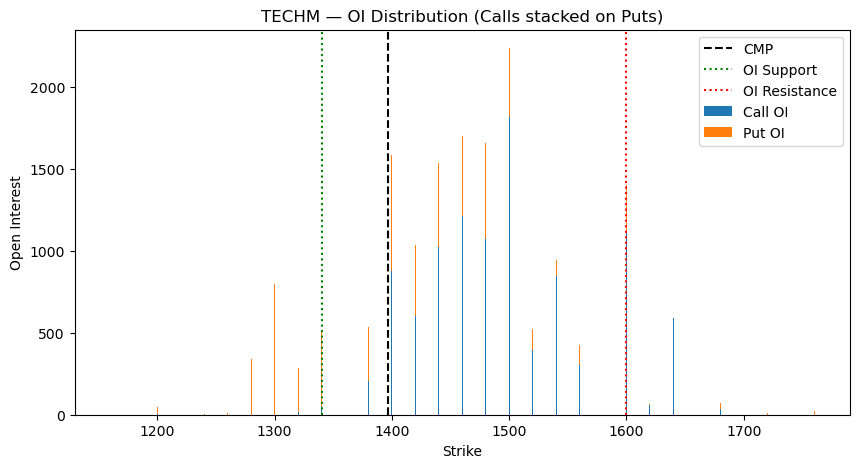

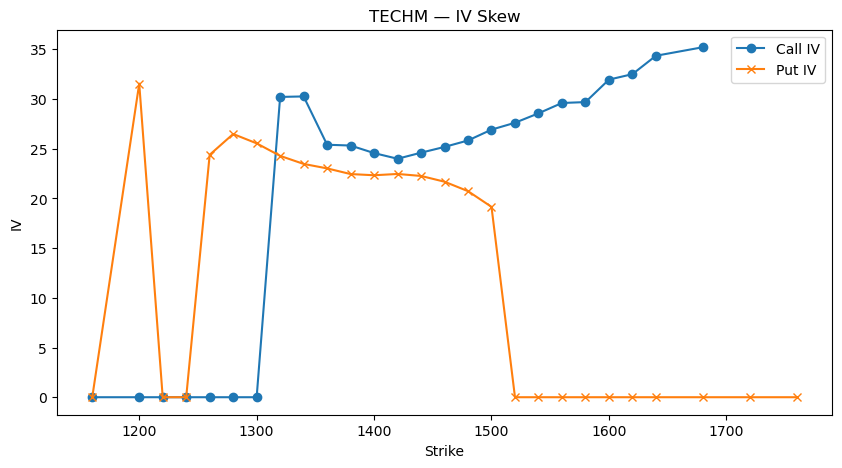

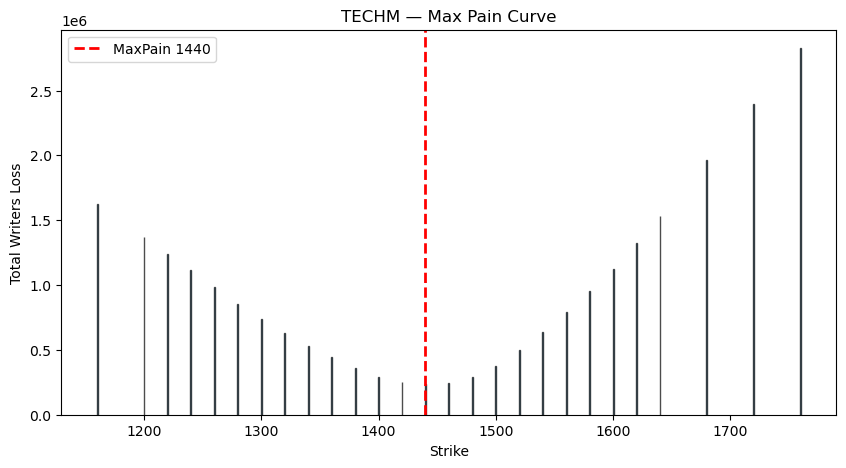

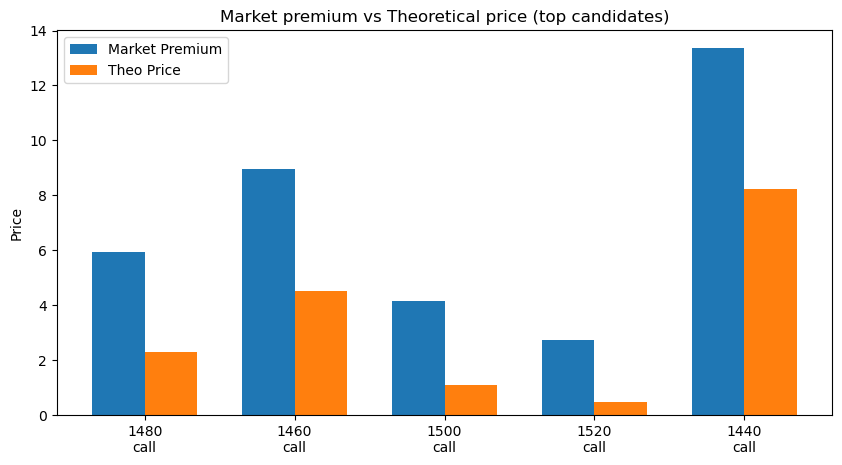

### Position Sizing Suggestion

- Fixed Fraction (1% risk of capital): ₹2,000.00

- Kelly fraction (naive) ≈ 0.0000 → 0.00% of capital

---

✅ Dashboard complete — examine the plots and the 'Top Trade Candidates' table above.

{'signal': {'symbol': 'TECHM',
  'expiry': '25-Nov-2025',
  'cmp': 1396.8,
  'max_pain': 1440.0,
  'pcr': 0.595247,
  'final_signal': 'BEARISH',
  'confidence_pct': 20.833333333333336,
  'total_score': -5,
  'max_pain_signal': {'signal': 'WEAK_BULLISH',
   'strength': 1,
   'distance_pct': 3.0927835051546424,
   'reason': 'CMP below Max Pain (3.09%) but PCR=0.60 (not confirming)'},
  'pcr_signal': {'signal': 'BEARISH',
   'strength': 2,
   'reason': 'Extreme bullish sentiment (PCR=0.60) → Contrarian bearish'},
  'oi_signal': {'signal': 'NEUTRAL',
   'strength': 0,
   'reason': 'Mid-range between support 1300 and resistance 1500',
   'support': 1300.0,
   'resistance': 1500.0,
   'position_pct': 48.39999999999998},
  'iv_signal': {'signal': 'NEUTRAL',
   'strength': 0,
   'reason': 'Moderate IV (23.4%) | Call IV > Put IV (bullish skew)',
   'atm_iv': 23.445,
   'iv_skew': -7.2780000000000005},
  'oi_analysis': {'max_call_oi_strike': 1500.0,
   'max_put_oi_strike': 1300.0,
   'top_call_s

In [23]:
# Cell 11 — Trader's Dashboard
# Paste this into a new notebook cell (after Cells 1-10 have run successfully).
# It will produce textual summary, printable tables and several matplotlib plots
# that help you interpret signals, liquidity, IV skew, OI structure and trade candidates.

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Configuration
OUTPUT_CANDIDATES_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "nse_options_analysis_pro", "historical_tracking")
ensure_dir(OUTPUT_CANDIDATES_DIR)  # from earlier cells
plt.rcParams["figure.figsize"] = (10, 5)

def dashboard_for(symbol: str, expiry: str = None, days_to_expiry: int = 7, capital: float = 200000.0, top_n: int = 8):
    """
    Run a trader-style dashboard for `symbol` and `expiry`.
    - Uses functions defined in prior cells: load_option_chain, generate_combined_signal,
      recommend_strikes_v2, oi_weighted_support_resistance, expected_move, bs_price_and_greeks.
    - Creates plots and prints summary + recommendations table.
    """
    # --- Resolve expiry if not provided (pick nearest) ---
    if expiry is None:
        equity_files = sorted([f for f in os.listdir(BASE_DIR) if f.startswith('Equities_Analysis_')])
        if not equity_files:
            raise RuntimeError("No Equities_Analysis_<expiry>.csv files found. Run Cell 1 first.")
        expiry = equity_files[0].replace('Equities_Analysis_', '').replace('.csv', '')
    
    # --- Load data / signal ---
    df_chain = load_option_chain(symbol, expiry, is_index=False)
    if df_chain is None or df_chain.empty:
        display(Markdown(f"**No option chain found for {symbol} {expiry}**"))
        return
    
    signal = generate_combined_signal(symbol, expiry, is_index=False)
    if signal is None:
        display(Markdown(f"**No signal generated for {symbol} {expiry}**"))
        return
    
    # --- Basic summary card ---
    cmp = signal.get('cmp')
    max_pain = signal.get('max_pain')
    pcr = signal.get('pcr')
    final_signal = signal.get('final_signal')
    score = signal.get('total_score')
    confidence = signal.get('confidence_pct')
    atm_iv = (signal.get('iv_analysis') or {}).get('atm_call_iv') or 0.0
    support, resistance = oi_weighted_support_resistance(df_chain)
    em = expected_move(cmp, atm_iv/100.0 if atm_iv else 0.25, days_to_expiry)
    
    display(Markdown(f"## DASHBOARD — {symbol}  |  Expiry: {expiry}"))
    display(Markdown(f"**CMP:** ₹{cmp:.2f}   •   **Max Pain:** ₹{(max_pain if max_pain is not None else 'N/A')}   •   **PCR:** {pcr}"))
    display(Markdown(f"**Final Signal:** **{final_signal}**   •   **Score:** {score}   •   **Confidence:** {confidence:.1f}%"))
    display(Markdown(f"**ATM IV:** {atm_iv:.2f}%   •   **Expected 1σ move ({days_to_expiry}d):** ±{em:.2f}"))
    display(Markdown(f"**OI-weighted Support:** {support}   •   **OI-weighted Resistance:** {resistance}"))
    display(Markdown("---"))
    
    # --- Prepare option-chain DataFrame: ensure numeric and sorted by Strike ---
    df = df_chain.copy()
    df['Strike'] = pd.to_numeric(df['Strike'], errors='coerce')
    for col in ['Call_OI', 'Put_OI', 'Call_LTP', 'Put_LTP', 'CE_IV', 'PE_IV']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values('Strike').reset_index(drop=True)
    
    # --- Generate recommendations (v2) and save candidates ---
    recs_struct = recommend_strikes_v2(signal, df, days_to_expiry=days_to_expiry)
    recs = recs_struct.get('all_trades', []) or []
    # Save top_n candidates for later backtest (append)
    if recs:
        rows = []
        today = pd.Timestamp.now().strftime("%Y-%m-%d")
        for rec in recs[:top_n]:
            rows.append({
                'Date': today,
                'Symbol': symbol,
                'Expiry': expiry,
                'Strike': rec.get('Strike'),
                'Kind': rec.get('kind'),
                'Premium': rec.get('premium'),
                'Theo': rec.get('theo_price'),
                'Delta': rec.get('delta'),
                'ProbITM': rec.get('prob_itm'),
                'P_touch': rec.get('p_touch'),
                'Edge': rec.get('edge'),
                'Score': rec.get('score'),
                'Reason': rec.get('reason')
            })
        cand_df = pd.DataFrame(rows)
        cand_path = os.path.join(OUTPUT_CANDIDATES_DIR, f"{symbol}_{expiry}_candidates.csv")
        if os.path.exists(cand_path):
            old = pd.read_csv(cand_path)
            new = pd.concat([old, cand_df], ignore_index=True)
            new.to_csv(cand_path, index=False)
        else:
            cand_df.to_csv(cand_path, index=False)
        display(Markdown(f"Saved {len(rows)} trade candidates to `{cand_path}`"))
    else:
        cand_df = pd.DataFrame()
        display(Markdown("No candidate trades produced by the v2 recommender."))
    
    # --- Present trade table (top-ranked) ---
    if recs:
        table = pd.DataFrame(recs)
        # normalize and round columns for display
        for c in ['Strike', 'theo_price', 'premium', 'delta', 'prob_itm', 'p_touch', 'edge', 'score']:
            if c in table.columns:
                table[c] = pd.to_numeric(table[c], errors='coerce')
        table_display = table[['Strike','kind','premium','theo_price','delta','prob_itm','p_touch','edge','score','reason']].copy()
        table_display.columns = ['Strike','Kind','Premium','Theo','Delta','ProbITM','P_touch','Edge','Score','Reason']
        display(Markdown("### Top Trade Candidates (ranked)"))
        display(table_display.head(top_n).style.format({
            'Strike': '{:.0f}', 'Premium': '{:.2f}', 'Theo': '{:.2f}', 'Delta': '{:.3f}',
            'ProbITM': '{:.3f}', 'P_touch': '{:.3f}', 'Edge': '{:.2f}', 'Score': '{:.4f}'
        }))
    else:
        display(Markdown("### No trades to display"))
    
    # --- PLOT 1: OI stacked bar (Call_OI vs Put_OI) ---
    fig, ax = plt.subplots()
    strikes = df['Strike'].values
    call_oi = df['Call_OI'].fillna(0).values
    put_oi = df['Put_OI'].fillna(0).values
    ax.bar(strikes, call_oi, label='Call OI')
    ax.bar(strikes, put_oi, bottom=call_oi, label='Put OI')
    ax.set_xlabel('Strike')
    ax.set_ylabel('Open Interest')
    ax.set_title(f'{symbol} — OI Distribution (Calls stacked on Puts)')
    ax.axvline(cmp, color='black', linestyle='--', label='CMP')
    if support is not None:
        ax.axvline(support, color='green', linestyle=':', label='OI Support')
    if resistance is not None:
        ax.axvline(resistance, color='red', linestyle=':', label='OI Resistance')
    ax.legend()
    plt.show()
    
    # --- PLOT 2: IV Skew (CE_IV & PE_IV) ---
    fig, ax = plt.subplots()
    if 'CE_IV' in df.columns and 'PE_IV' in df.columns:
        ax.plot(strikes, df['CE_IV'], marker='o', label='Call IV')
        ax.plot(strikes, df['PE_IV'], marker='x', label='Put IV')
        ax.set_xlabel('Strike')
        ax.set_ylabel('IV')
        ax.set_title(f'{symbol} — IV Skew')
        ax.legend()
        plt.show()
    else:
        display(Markdown("IV data (CE_IV/PE_IV) not available for IV skew plot."))
    
    # --- PLOT 3: Max Pain loss curve (total loss vs strike) ---
    # compute total loss for each candidate expiry strike (writers' loss)
    try:
        strikes_np = df['Strike'].values.astype(float)
        call_oi_np = df['Call_OI'].fillna(0).values.astype(float)
        put_oi_np = df['Put_OI'].fillna(0).values.astype(float)
        total_losses = []
        for s_try in strikes_np:
            call_loss = np.sum(np.clip(s_try - strikes_np, 0, None) * call_oi_np)
            put_loss = np.sum(np.clip(strikes_np - s_try, 0, None) * put_oi_np)
            total_losses.append(call_loss + put_loss)
        fig, ax = plt.subplots()
        ax.bar(strikes_np, total_losses, edgecolor='black', alpha=0.7)
        mp_idx = int(np.argmin(total_losses))
        ax.axvline(strikes_np[mp_idx], color='red', linestyle='--', linewidth=2, label=f"MaxPain {int(strikes_np[mp_idx])}")
        ax.set_xlabel('Strike')
        ax.set_ylabel('Total Writers Loss')
        ax.set_title(f'{symbol} — Max Pain Curve')
        ax.legend()
        plt.show()
    except Exception as e:
        display(Markdown(f"Could not compute Max Pain plot: {e}"))
    
    # --- PLOT 4: Market premium vs Theoretical price for top candidates ---
    if recs:
        top_plot = pd.DataFrame(recs[:top_n]).copy()
        top_plot['premium'] = pd.to_numeric(top_plot['premium'], errors='coerce')
        top_plot['theo_price'] = pd.to_numeric(top_plot['theo_price'], errors='coerce')
        fig, ax = plt.subplots()
        x = np.arange(len(top_plot))
        width = 0.35
        ax.bar(x - width/2, top_plot['premium'].fillna(0), width, label='Market Premium')
        ax.bar(x + width/2, top_plot['theo_price'].fillna(0), width, label='Theo Price')
        ax.set_xticks(x)
        ax.set_xticklabels([f"{int(k)}\n{p['kind']}" for k,p in zip(top_plot['Strike'], top_plot.to_dict('records'))], rotation=0)
        ax.set_ylabel('Price')
        ax.set_title('Market premium vs Theoretical price (top candidates)')
        ax.legend()
        plt.show()
    
    # --- Position sizing quick suggestion (fixed fraction + Kelly skeleton) ---
    fixed_budget = fixed_fraction_size(capital, 1.0)  # 1% default risk
    # compute naive estimated edge/win_prob for top candidate (if available)
    kelly_msg = "Kelly not computed (insufficient estimates)"
    if recs:
        first = recs[0]
        # naive win_prob = 1 - ProbITM for sells, = ProbITM for buys; payoff_ratio naively estimated
        if first.get('prob_itm') is not None:
            if first['kind'] in ('put','call') and 'SELL' in (first.get('reason') or '').upper():
                win_prob = 1.0 - (first.get('prob_itm') or 0.0)
            else:
                win_prob = (first.get('prob_itm') or 0.0)
            # naive average win ~ premium, avg loss ~ strike * 0.1 (very approximate)
            avg_win = float(first.get('premium') or 0.0)
            avg_loss = (float(first.get('Strike')) * 0.10) if float(first.get('Strike'))>0 else 1.0
            payoff_ratio = (avg_win / avg_loss) if avg_loss>0 else 0.0
            kelly_frac = kelly_fraction(avg_win/ (avg_loss if avg_loss else 1.0), win_prob, payoff_ratio) if payoff_ratio>0 else 0.0
            kelly_msg = f"Kelly fraction (naive) ≈ {kelly_frac:.4f} → {kelly_frac*100:.2f}% of capital"
    display(Markdown("### Position Sizing Suggestion"))
    display(Markdown(f"- Fixed Fraction (1% risk of capital): ₹{fixed_budget:,.2f}"))
    display(Markdown(f"- {kelly_msg}"))
    display(Markdown("---"))
    display(Markdown("✅ Dashboard complete — examine the plots and the 'Top Trade Candidates' table above."))
    return {
        'signal': signal,
        'candidates': recs,
        'candidate_df': cand_df if not cand_df.empty else None,
        'oi_summary': {'support': support, 'resistance': resistance},
        'max_pain_strike': int(strikes_np[np.argmin(total_losses)]) if 'total_losses' in locals() else None
    }

# Example usage:
dashboard_for('TECHM', expiry='25-Nov-2025', days_to_expiry=7, capital=200000.0, top_n=8)